In [1]:
import io
import requests

import pandas as pd
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pdf = pd.read_parquet('ftransfer_elasticc_2023-02-15_946675/training-transient/classId=124')

In [3]:
def extract_history(history_list: list, field: str) -> list:
    """Extract the historical measurements contained in the alerts
    for the parameter `field`.

    Parameters
    ----------
    history_list: list of dict
        List of dictionary from alert[history].
    field: str
        The field name for which you want to extract the data. It must be
        a key of elements of history_list
    
    Returns
    ----------
    measurement: list
        List of all the `field` measurements contained in the alerts.
    """
    if history_list is None:
        return []
    try:
        measurement = [obs[field] for obs in history_list]
    except KeyError:
        print('{} not in history data'.format(field))
        measurement = []

    return measurement

def extract_field(alert: dict, category: str, field: str) -> np.array:
    """ Concatenate current and historical observation data for a given field.
    
    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    category: str
        prvDiaSources or prvDiaForcedSources
    field: str
        Name of the field to extract.
    
    Returns
    ----------
    data: np.array
        List containing previous measurements and current measurement at the
        end. If `field` is not in the category, data will be
        [alert['diaSource'][field]].
    """
    data = np.concatenate(
        [
            [alert["diaSource"][field]],
            extract_history(alert[category], field)
        ]
    )
    return data

In [4]:
pdf['classId'] = 124

In [45]:
pdf['cpsFlux'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFlux'), axis=1)
pdf['cpsFluxErr'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFluxErr'), axis=1)
pdf['cfilterName'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'filterName'), axis=1)
pdf['cmidPointTai'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'midPointTai'), axis=1)

cols = ['alertId', 'classId', 'cmidPointTai', 'cpsFlux', 'cpsFluxErr', 'cfilterName']
sub = pdf[cols]
sub

,alertId,classId,cmidPointTai,cpsFlux,cpsFluxErr,cfilterName
0,265766796068,124,"[60548.0394, 60396.4084, 60414.4173, 60417.346...","[-2585.48486328125, -1294.6854248046875, -1070...","[449.3246154785156, 1201.7781982421875, 382.33...","[z, Y, r, i, z, i, z, z, Y, Y, Y, z, i, i, z, ..."
1,265766796069,124,"[60548.0641, 60396.4084, 60414.4173, 60417.346...","[-1323.7060546875, -1294.6854248046875, -1070....","[327.0087890625, 1201.7781982421875, 382.33102...","[i, Y, r, i, z, i, z, z, Y, Y, Y, z, i, i, z, ..."
2,224224972030,124,"[60400.4033, 60365.2235, 60365.2244, 60365.246...","[-16152.490234375, -18479.498046875, -21770.10...","[1988.796630859375, 3731.3349609375, 3753.0253...","[z, Y, Y, Y, Y, Y, Y, i, i, r, r, r, i, g, g, ..."
3,239345540011,124,"[60432.3844, 60396.4115, 60414.4211, 60417.343...","[-6396.4140625, -6495.8369140625, -1234.343627...","[486.0912780761719, 1404.8216552734375, 424.59...","[z, Y, r, i, z, i, z, Y, Y, i, z, Y]"
4,239345540016,124,"[60432.4129, 60396.4115, 60414.4211, 60417.343...","[-5329.07275390625, -6495.8369140625, -1234.34...","[464.8493347167969, 1404.8216552734375, 424.59...","[z, Y, r, i, z, i, z, Y, Y, i, z, Y, z, i, i, ..."
...,...,...,...,...,...,...
32208,184580716044,124,"[60603.1366, 60275.0612, 60275.0849, 60288.036...","[-3892.512451171875, -3477.767333984375, -4324...","[390.1531982421875, 815.84716796875, 1586.5212...","[i, z, Y, r, i, r, g, Y, Y, i, z, z, z, i, z, ..."
32209,184580716045,124,"[60603.214, 60275.0612, 60275.0849, 60288.0364...","[-2351.4140625, -3477.767333984375, -4324.1826...","[558.2762451171875, 815.84716796875, 1586.5212...","[z, z, Y, r, i, r, g, Y, Y, i, z, z, z, i, z, ..."
32210,47677850071,124,"[60394.0011, 60282.2813, 60282.3034, 60283.345...","[-50749.03125, -43242.45703125, -47813.7421875...","[649.681884765625, 536.7491455078125, 579.0622...","[i, i, z, r, r, i, r, i, r, i, z, Y, g, r, Y, ..."
32211,172509324005,124,"[60392.1809, 60382.341, 60382.3641, 60386.3919...","[-575612.1875, -434787.09375, -319788.40625, -...","[3739.03564453125, 2213.0888671875, 1705.59606...","[Y, i, r, Y, Y, z]"


In [46]:
def f(x):
    y = len(list(set(x))) > 1
    #sample function
    return y 

df = sub["cfilterName"].apply(f)
sub = sub[df].reset_index(drop=True)

In [47]:
def f(x):
    y = len(x) < 5
    #sample function
    return y 

df = sub["cmidPointTai"].apply(f)
sub = sub[df].reset_index(drop=True)

In [48]:
sub

,index,alertId,classId,cmidPointTai,cpsFlux,cpsFluxErr,cfilterName
0,236,11221982004,124,"[60476.3636, 60465.327, 60465.3525, 60476.3394]","[23403.47265625, 12062.66796875, 12077.7470703...","[609.5753173828125, 591.8997192382812, 539.466...","[i, i, r, z]"
1,237,11221982003,124,"[60476.3394, 60465.327, 60465.3525]","[23592.341796875, 12062.66796875, 12077.747070...","[764.3668212890625, 591.8997192382812, 539.466...","[z, i, r]"
2,271,219820620002,124,"[60476.3421, 60465.3716, 60465.395]","[15939.1728515625, 4890.14501953125, 7012.2636...","[545.2708740234375, 226.1724853515625, 277.463...","[z, r, i]"
3,272,219820620003,124,"[60476.3663, 60465.3716, 60465.395, 60476.3421]","[14132.708984375, 4890.14501953125, 7012.26367...","[339.8009948730469, 226.1724853515625, 277.463...","[i, r, i, z]"
4,599,182758248076,124,"[60607.3555, 60599.2935, 60599.317, 60602.3742]","[2188.124267578125, 6216.42578125, 5186.155761...","[431.473876953125, 1687.279052734375, 1700.039...","[i, Y, Y, z]"
...,...,...,...,...,...,...,...
527,32001,60723302017,124,"[60523.4246, 60485.434, 60505.4246, 60505.4376]","[3442.283447265625, 3461.431640625, 4790.96386...","[708.4021606445312, 970.1984252929688, 722.581...","[i, i, i, z]"
528,32061,41343216002,124,"[60450.2914, 60443.3269, 60443.3529]","[29266.720703125, 3294.499755859375, 6566.2700...","[2327.561767578125, 573.8157958984375, 810.239...","[Y, g, r]"
529,32097,55823498001,124,"[60476.4321, 60414.4121]","[-3463020.5, -1071672.375]","[16766.94921875, 5430.6689453125]","[Y, r]"
530,32151,219850982007,124,"[60488.4274, 60484.2966, 60484.3212, 60488.416]","[48118.02734375, 35878.43359375, 50733.3007812...","[1044.3154296875, 1035.912841796875, 2168.7841...","[z, z, Y, i]"


In [9]:
df = sub.explode(column=["cmidPointTai", "cpsFlux", "cpsFluxErr", "cfilterName"]).sort_values(by=["index", "cfilterName"])

df = df.rename(columns={"alertId": "object_id","cmidPointTai": "mjd", "cpsFlux": "flux", "cpsFluxErr": "flux_error", "cfilterName": "filter"})

df

,level_0,index,object_id,classId,mjd,flux,flux_error,filter
0,0,0,265766796068,124,60396.4084,-1294.685425,1201.778198,Y
0,0,0,265766796068,124,60422.3779,-668.602722,994.260803,Y
0,0,0,265766796068,124,60423.3441,-4463.530273,1315.829102,Y
0,0,0,265766796068,124,60423.3673,-2920.85791,1249.800415,Y
0,0,0,265766796068,124,60452.2891,-2296.649902,1207.240845,Y
...,...,...,...,...,...,...,...,...
27413,30744,32210,47677850071,124,60357.1639,-55601.625,604.307495,z
27413,30744,32210,47677850071,124,60365.0526,-56161.933594,847.257385,z
27413,30744,32210,47677850071,124,60368.0875,-55322.558594,647.68158,z
27413,30744,32210,47677850071,124,60392.0174,-57437.652344,798.358032,z


In [10]:
filters = df["filter"]
filters = list(np.unique(filters))
filters

['Y', 'g', 'i', 'r', 'u', 'z']

In [11]:
from astronet.preprocess import generate_gp_all_objects, remap_filters, generate_gp_single_event
from astronet.constants import *

In [12]:
df = remap_filters(df, filter_map=ELASTICC_FILTER_MAP)
df

,level_0,index,object_id,classId,mjd,flux,flux_error,filter
0,0,0,265766796068,124,60396.4084,-1294.685425,1201.778198,lssty
0,0,0,265766796068,124,60422.3779,-668.602722,994.260803,lssty
0,0,0,265766796068,124,60423.3441,-4463.530273,1315.829102,lssty
0,0,0,265766796068,124,60423.3673,-2920.85791,1249.800415,lssty
0,0,0,265766796068,124,60452.2891,-2296.649902,1207.240845,lssty
...,...,...,...,...,...,...,...,...
27413,30744,32210,47677850071,124,60357.1639,-55601.625,604.307495,lsstz
27413,30744,32210,47677850071,124,60365.0526,-56161.933594,847.257385,lsstz
27413,30744,32210,47677850071,124,60368.0875,-55322.558594,647.68158,lsstz
27413,30744,32210,47677850071,124,60392.0174,-57437.652344,798.358032,lsstz


In [13]:
ddf = df.drop(columns=["index"])

In [14]:
alert_list = list(np.unique(ddf["object_id"]))
len(alert_list)

27412

In [27]:
# %%timeit -n1 -r1
generated_gp_dataset = generate_gp_all_objects(alert_list, ddf)

COMPLETED OBJECT ID:2358184012
COMPLETED OBJECT ID:2358184013
COMPLETED OBJECT ID:2358184016
COMPLETED OBJECT ID:2358184019
COMPLETED OBJECT ID:2358184020
COMPLETED OBJECT ID:2358184021
COMPLETED OBJECT ID:2358184022
COMPLETED OBJECT ID:2358184024
COMPLETED OBJECT ID:2358184025
COMPLETED OBJECT ID:2358184026
COMPLETED OBJECT ID:2358184027
COMPLETED OBJECT ID:2358184029
COMPLETED OBJECT ID:2358184030
COMPLETED OBJECT ID:2358184031
COMPLETED OBJECT ID:2358184033
COMPLETED OBJECT ID:2358184037
COMPLETED OBJECT ID:2358184038
COMPLETED OBJECT ID:2358184040
COMPLETED OBJECT ID:2358184042
COMPLETED OBJECT ID:2358184043
COMPLETED OBJECT ID:2358184044
COMPLETED OBJECT ID:2358184047
COMPLETED OBJECT ID:2358184048
COMPLETED OBJECT ID:2358184049
COMPLETED OBJECT ID:2358184050
COMPLETED OBJECT ID:2358184051
COMPLETED OBJECT ID:2358184053
COMPLETED OBJECT ID:2358184054
COMPLETED OBJECT ID:2358184056
COMPLETED OBJECT ID:2358184057
COMPLETED OBJECT ID:2358184058
COMPLETED OBJECT ID:2358184059
COMPLETE

COMPLETED OBJECT ID:4906870030
COMPLETED OBJECT ID:4906870031
COMPLETED OBJECT ID:4906870032
COMPLETED OBJECT ID:4906870033
COMPLETED OBJECT ID:4906870034
COMPLETED OBJECT ID:4906870035
COMPLETED OBJECT ID:4906870036
COMPLETED OBJECT ID:4906870037
COMPLETED OBJECT ID:4906870038
COMPLETED OBJECT ID:4906870039
COMPLETED OBJECT ID:4906870040
COMPLETED OBJECT ID:4906870041
COMPLETED OBJECT ID:4906870043
COMPLETED OBJECT ID:4906870049
COMPLETED OBJECT ID:4906870050
COMPLETED OBJECT ID:4906870051
COMPLETED OBJECT ID:4906870052
COMPLETED OBJECT ID:4906870053
COMPLETED OBJECT ID:4906870054
COMPLETED OBJECT ID:4906870055
COMPLETED OBJECT ID:4906870056
COMPLETED OBJECT ID:4906870057
COMPLETED OBJECT ID:4906870058
COMPLETED OBJECT ID:4906870059
COMPLETED OBJECT ID:4906870060
COMPLETED OBJECT ID:4906870061
COMPLETED OBJECT ID:4906870062
COMPLETED OBJECT ID:4906870063
COMPLETED OBJECT ID:4906870064
COMPLETED OBJECT ID:4906870065
COMPLETED OBJECT ID:4906870066
COMPLETED OBJECT ID:4906870067
COMPLETE

COMPLETED OBJECT ID:11221982027
COMPLETED OBJECT ID:11221982028
COMPLETED OBJECT ID:11221982029
COMPLETED OBJECT ID:11221982030
COMPLETED OBJECT ID:11221982031
COMPLETED OBJECT ID:11221982032
COMPLETED OBJECT ID:11221982033
COMPLETED OBJECT ID:11221982034
COMPLETED OBJECT ID:11221982035
COMPLETED OBJECT ID:11221982036
COMPLETED OBJECT ID:11221982037
COMPLETED OBJECT ID:11221982038
COMPLETED OBJECT ID:11221982039
COMPLETED OBJECT ID:11221982040
COMPLETED OBJECT ID:11221982041
COMPLETED OBJECT ID:11221982042
COMPLETED OBJECT ID:11221982043
COMPLETED OBJECT ID:11221982044
COMPLETED OBJECT ID:11221982045
COMPLETED OBJECT ID:11221982046
COMPLETED OBJECT ID:11221982047
COMPLETED OBJECT ID:11221982048
COMPLETED OBJECT ID:11221982049
COMPLETED OBJECT ID:11221982050
COMPLETED OBJECT ID:11221982051
COMPLETED OBJECT ID:11221982052
COMPLETED OBJECT ID:11221982053
COMPLETED OBJECT ID:11221982054
COMPLETED OBJECT ID:11221982055
COMPLETED OBJECT ID:11221982056
COMPLETED OBJECT ID:11221982057
COMPLETE

COMPLETED OBJECT ID:13862562073
COMPLETED OBJECT ID:13862562075
COMPLETED OBJECT ID:13862562076
COMPLETED OBJECT ID:13862562077
COMPLETED OBJECT ID:13862562078
COMPLETED OBJECT ID:14563724012
COMPLETED OBJECT ID:14563724014
COMPLETED OBJECT ID:14563724015
COMPLETED OBJECT ID:14563724017
COMPLETED OBJECT ID:14563724018
COMPLETED OBJECT ID:14563724019
COMPLETED OBJECT ID:14563724021
COMPLETED OBJECT ID:14563724022
COMPLETED OBJECT ID:14563724023
COMPLETED OBJECT ID:14563724024
COMPLETED OBJECT ID:14563724026
COMPLETED OBJECT ID:14563724028
COMPLETED OBJECT ID:14563724030
COMPLETED OBJECT ID:14563724031
COMPLETED OBJECT ID:14563724034
COMPLETED OBJECT ID:14563724035
COMPLETED OBJECT ID:14563724036
COMPLETED OBJECT ID:14563724037
COMPLETED OBJECT ID:14563724038
COMPLETED OBJECT ID:14563724040
COMPLETED OBJECT ID:14563724041
COMPLETED OBJECT ID:14563724042
COMPLETED OBJECT ID:14563724043
COMPLETED OBJECT ID:14563724047
COMPLETED OBJECT ID:14563724048
COMPLETED OBJECT ID:14563724049
COMPLETE

COMPLETED OBJECT ID:16880396073
COMPLETED OBJECT ID:16880396074
COMPLETED OBJECT ID:16880396079
COMPLETED OBJECT ID:16880396081
COMPLETED OBJECT ID:16880396085
COMPLETED OBJECT ID:16880396086
COMPLETED OBJECT ID:16880396087
COMPLETED OBJECT ID:16880396088
COMPLETED OBJECT ID:16880396102
COMPLETED OBJECT ID:16880396103
COMPLETED OBJECT ID:16880396105
COMPLETED OBJECT ID:16880396107
COMPLETED OBJECT ID:16952298066
COMPLETED OBJECT ID:16952298070
COMPLETED OBJECT ID:17064872051
COMPLETED OBJECT ID:17064872052
COMPLETED OBJECT ID:17064872053
COMPLETED OBJECT ID:17064872054
COMPLETED OBJECT ID:17064872055
COMPLETED OBJECT ID:17064872056
COMPLETED OBJECT ID:17064872057
COMPLETED OBJECT ID:17064872058
COMPLETED OBJECT ID:17064872059
COMPLETED OBJECT ID:17064872060
COMPLETED OBJECT ID:17064872061
COMPLETED OBJECT ID:17064872062
COMPLETED OBJECT ID:17574422069
COMPLETED OBJECT ID:17574422070
COMPLETED OBJECT ID:17574422071
COMPLETED OBJECT ID:17574422072
COMPLETED OBJECT ID:17574422073
COMPLETE

COMPLETED OBJECT ID:19072140028
COMPLETED OBJECT ID:19072140029
COMPLETED OBJECT ID:19072140030
COMPLETED OBJECT ID:19072140031
COMPLETED OBJECT ID:19072140032
COMPLETED OBJECT ID:19072140033
COMPLETED OBJECT ID:19072140034
COMPLETED OBJECT ID:19072140035
COMPLETED OBJECT ID:19072140036
COMPLETED OBJECT ID:19072140037
COMPLETED OBJECT ID:19072140038
COMPLETED OBJECT ID:19072140039
COMPLETED OBJECT ID:19072140040
COMPLETED OBJECT ID:19072140041
COMPLETED OBJECT ID:19072140042
COMPLETED OBJECT ID:19072140043
COMPLETED OBJECT ID:19072140044
COMPLETED OBJECT ID:19072140045
COMPLETED OBJECT ID:19072140046
COMPLETED OBJECT ID:19072140047
COMPLETED OBJECT ID:19072140048
COMPLETED OBJECT ID:19072140049
COMPLETED OBJECT ID:19072140050
COMPLETED OBJECT ID:19072140051
COMPLETED OBJECT ID:19072140052
COMPLETED OBJECT ID:19072140053
COMPLETED OBJECT ID:19072140054
COMPLETED OBJECT ID:19072140055
COMPLETED OBJECT ID:19072140056
COMPLETED OBJECT ID:19072140057
COMPLETED OBJECT ID:19072140059
COMPLETE

COMPLETED OBJECT ID:21071400027
COMPLETED OBJECT ID:21071400029
COMPLETED OBJECT ID:21071400032
COMPLETED OBJECT ID:21071400033
COMPLETED OBJECT ID:21071400035
COMPLETED OBJECT ID:21071400036
COMPLETED OBJECT ID:21071400037
COMPLETED OBJECT ID:21071400038
COMPLETED OBJECT ID:21071400039
COMPLETED OBJECT ID:21071400040
COMPLETED OBJECT ID:21071400041
COMPLETED OBJECT ID:21071400042
COMPLETED OBJECT ID:21071400043
COMPLETED OBJECT ID:21071400045
COMPLETED OBJECT ID:21071400046
COMPLETED OBJECT ID:21071400048
COMPLETED OBJECT ID:21071400049
COMPLETED OBJECT ID:21071400050
COMPLETED OBJECT ID:21071400051
COMPLETED OBJECT ID:21071400052
COMPLETED OBJECT ID:21071400053
COMPLETED OBJECT ID:21071400054
COMPLETED OBJECT ID:21071400055
COMPLETED OBJECT ID:21071400056
COMPLETED OBJECT ID:21071400057
COMPLETED OBJECT ID:21071400058
COMPLETED OBJECT ID:21071400059
COMPLETED OBJECT ID:21071400060
COMPLETED OBJECT ID:21071400061
COMPLETED OBJECT ID:21071400062
COMPLETED OBJECT ID:21071400063
COMPLETE

COMPLETED OBJECT ID:23529022067
COMPLETED OBJECT ID:23529022068
COMPLETED OBJECT ID:23529022069
COMPLETED OBJECT ID:23529022070
COMPLETED OBJECT ID:23529022071
COMPLETED OBJECT ID:23529022073
COMPLETED OBJECT ID:23529022074
COMPLETED OBJECT ID:23529022075
COMPLETED OBJECT ID:23529022076
COMPLETED OBJECT ID:23529022077
COMPLETED OBJECT ID:23529022078
COMPLETED OBJECT ID:23529022079
COMPLETED OBJECT ID:23529022081
COMPLETED OBJECT ID:23529022082
COMPLETED OBJECT ID:23529022083
COMPLETED OBJECT ID:25511144012
COMPLETED OBJECT ID:25511144013
COMPLETED OBJECT ID:25511144014
COMPLETED OBJECT ID:25511144015
COMPLETED OBJECT ID:25511144016
COMPLETED OBJECT ID:25511144017
COMPLETED OBJECT ID:25511144018
COMPLETED OBJECT ID:25511144019
COMPLETED OBJECT ID:25511144020
COMPLETED OBJECT ID:25511144021
COMPLETED OBJECT ID:25511144022
COMPLETED OBJECT ID:25511144023
COMPLETED OBJECT ID:25511144025
COMPLETED OBJECT ID:25511144026
COMPLETED OBJECT ID:25613728052
COMPLETED OBJECT ID:25613728053
COMPLETE

COMPLETED OBJECT ID:27667324070
COMPLETED OBJECT ID:27667324071
COMPLETED OBJECT ID:27667324072
COMPLETED OBJECT ID:27667324073
COMPLETED OBJECT ID:27667324074
COMPLETED OBJECT ID:27667324075
COMPLETED OBJECT ID:27667324076
COMPLETED OBJECT ID:27667324077
COMPLETED OBJECT ID:27781596040
COMPLETED OBJECT ID:27781596041
COMPLETED OBJECT ID:27781596042
COMPLETED OBJECT ID:27781596043
COMPLETED OBJECT ID:27781596044
COMPLETED OBJECT ID:27781596045
COMPLETED OBJECT ID:27781596046
COMPLETED OBJECT ID:27781596047
COMPLETED OBJECT ID:27781596048
COMPLETED OBJECT ID:27781596049
COMPLETED OBJECT ID:27781596050
COMPLETED OBJECT ID:27781596051
COMPLETED OBJECT ID:27781596052
COMPLETED OBJECT ID:27781596053
COMPLETED OBJECT ID:27781596054
COMPLETED OBJECT ID:27781596055
COMPLETED OBJECT ID:27781596056
COMPLETED OBJECT ID:27781596057
COMPLETED OBJECT ID:28129110012
COMPLETED OBJECT ID:28129110013
COMPLETED OBJECT ID:28129110014
COMPLETED OBJECT ID:28129110015
COMPLETED OBJECT ID:28129110016
COMPLETE

COMPLETED OBJECT ID:29466508044
COMPLETED OBJECT ID:29466508045
COMPLETED OBJECT ID:29466508046
COMPLETED OBJECT ID:29466508047
COMPLETED OBJECT ID:29466508048
COMPLETED OBJECT ID:29466508049
COMPLETED OBJECT ID:29466508050
COMPLETED OBJECT ID:29466508051
COMPLETED OBJECT ID:29466508054
COMPLETED OBJECT ID:29466508055
COMPLETED OBJECT ID:29466508056
COMPLETED OBJECT ID:29466508057
COMPLETED OBJECT ID:29466508058
COMPLETED OBJECT ID:29466508059
COMPLETED OBJECT ID:29466508060
COMPLETED OBJECT ID:29466508061
COMPLETED OBJECT ID:29466508062
COMPLETED OBJECT ID:29466508063
COMPLETED OBJECT ID:29466508064
COMPLETED OBJECT ID:29466508065
COMPLETED OBJECT ID:29466508066
COMPLETED OBJECT ID:29466508067
COMPLETED OBJECT ID:29466508068
COMPLETED OBJECT ID:29466508069
COMPLETED OBJECT ID:29466508070
COMPLETED OBJECT ID:29466508071
COMPLETED OBJECT ID:29466508072
COMPLETED OBJECT ID:29466508073
COMPLETED OBJECT ID:29466508074
COMPLETED OBJECT ID:29466508075
COMPLETED OBJECT ID:29466508076
COMPLETE

COMPLETED OBJECT ID:32419782013
COMPLETED OBJECT ID:32419782014
COMPLETED OBJECT ID:32419782015
COMPLETED OBJECT ID:32419782016
COMPLETED OBJECT ID:32419782017
COMPLETED OBJECT ID:32419782018
COMPLETED OBJECT ID:32419782019
COMPLETED OBJECT ID:32419782020
COMPLETED OBJECT ID:32419782021
COMPLETED OBJECT ID:32419782022
COMPLETED OBJECT ID:32419782023
COMPLETED OBJECT ID:32419782024
COMPLETED OBJECT ID:32419782027
COMPLETED OBJECT ID:32419782028
COMPLETED OBJECT ID:32419782029
COMPLETED OBJECT ID:32419782030
COMPLETED OBJECT ID:32419782031
COMPLETED OBJECT ID:32419782032
COMPLETED OBJECT ID:32419782033
COMPLETED OBJECT ID:32419782034
COMPLETED OBJECT ID:32419782035
COMPLETED OBJECT ID:32419782036
COMPLETED OBJECT ID:32419782037
COMPLETED OBJECT ID:32419782038
COMPLETED OBJECT ID:32419782039
COMPLETED OBJECT ID:32419782040
COMPLETED OBJECT ID:32419782041
COMPLETED OBJECT ID:32419782042
COMPLETED OBJECT ID:32419782043
COMPLETED OBJECT ID:32419782044
COMPLETED OBJECT ID:32419782045
COMPLETE

COMPLETED OBJECT ID:34666006064
COMPLETED OBJECT ID:34666006065
COMPLETED OBJECT ID:34666006066
COMPLETED OBJECT ID:34666006067
COMPLETED OBJECT ID:34666006068
COMPLETED OBJECT ID:34666006069
COMPLETED OBJECT ID:34666006070
COMPLETED OBJECT ID:34666006071
COMPLETED OBJECT ID:35932326089
COMPLETED OBJECT ID:36151640044
COMPLETED OBJECT ID:36151640060
COMPLETED OBJECT ID:36229552115
COMPLETED OBJECT ID:36229552116
COMPLETED OBJECT ID:36549792012
COMPLETED OBJECT ID:36549792013
COMPLETED OBJECT ID:36549792014
COMPLETED OBJECT ID:36549792015
COMPLETED OBJECT ID:36549792016
COMPLETED OBJECT ID:36549792017
COMPLETED OBJECT ID:36549792018
COMPLETED OBJECT ID:36549792019
COMPLETED OBJECT ID:36549792020
COMPLETED OBJECT ID:36549792021
COMPLETED OBJECT ID:36549792022
COMPLETED OBJECT ID:36549792024
COMPLETED OBJECT ID:36549792025
COMPLETED OBJECT ID:36549792026
COMPLETED OBJECT ID:36549792027
COMPLETED OBJECT ID:36549792028
COMPLETED OBJECT ID:36549792029
COMPLETED OBJECT ID:36549792030
COMPLETE

COMPLETED OBJECT ID:38415228091
COMPLETED OBJECT ID:38415228092
COMPLETED OBJECT ID:38415228093
COMPLETED OBJECT ID:38415228095
COMPLETED OBJECT ID:38415228097
COMPLETED OBJECT ID:38415228098
COMPLETED OBJECT ID:38415228099
COMPLETED OBJECT ID:38415228100
COMPLETED OBJECT ID:38415228102
COMPLETED OBJECT ID:38415228104
COMPLETED OBJECT ID:38415228105
COMPLETED OBJECT ID:38415228107
COMPLETED OBJECT ID:38415228109
COMPLETED OBJECT ID:38415228110
COMPLETED OBJECT ID:38415228113
COMPLETED OBJECT ID:38415228114
COMPLETED OBJECT ID:38415228115
COMPLETED OBJECT ID:38415228116
COMPLETED OBJECT ID:38415228117
COMPLETED OBJECT ID:38415228118
COMPLETED OBJECT ID:38515214012
COMPLETED OBJECT ID:38515214013
COMPLETED OBJECT ID:38515214014
COMPLETED OBJECT ID:38515214015
COMPLETED OBJECT ID:38515214016
COMPLETED OBJECT ID:38515214017
COMPLETED OBJECT ID:38515214020
COMPLETED OBJECT ID:38515214021
COMPLETED OBJECT ID:38515214022
COMPLETED OBJECT ID:38515214023
COMPLETED OBJECT ID:38515214024
COMPLETE

COMPLETED OBJECT ID:40469668073
COMPLETED OBJECT ID:40469668074
COMPLETED OBJECT ID:40469668076
COMPLETED OBJECT ID:40469668078
COMPLETED OBJECT ID:40469668080
COMPLETED OBJECT ID:40469668081
COMPLETED OBJECT ID:40469668083
COMPLETED OBJECT ID:40469668084
COMPLETED OBJECT ID:40469668086
COMPLETED OBJECT ID:40469668087
COMPLETED OBJECT ID:40469668088
COMPLETED OBJECT ID:40469668089
COMPLETED OBJECT ID:40469668091
COMPLETED OBJECT ID:40469668092
COMPLETED OBJECT ID:40469668094
COMPLETED OBJECT ID:40469668095
COMPLETED OBJECT ID:40469668096
COMPLETED OBJECT ID:40469668097
COMPLETED OBJECT ID:40469668098
COMPLETED OBJECT ID:40469668100
COMPLETED OBJECT ID:40469668101
COMPLETED OBJECT ID:40469668102
COMPLETED OBJECT ID:40889520012
COMPLETED OBJECT ID:40889520014
COMPLETED OBJECT ID:40889520015
COMPLETED OBJECT ID:40889520016
COMPLETED OBJECT ID:40889520017
COMPLETED OBJECT ID:40889520019
COMPLETED OBJECT ID:40889520020
COMPLETED OBJECT ID:40889520021
COMPLETED OBJECT ID:40889520022
COMPLETE

COMPLETED OBJECT ID:45145508012
COMPLETED OBJECT ID:45145508016
COMPLETED OBJECT ID:45145508017
COMPLETED OBJECT ID:45145508018
COMPLETED OBJECT ID:45145508019
COMPLETED OBJECT ID:45145508021
COMPLETED OBJECT ID:45145508022
COMPLETED OBJECT ID:46018406056
COMPLETED OBJECT ID:46018406057
COMPLETED OBJECT ID:46018406058
COMPLETED OBJECT ID:46018406059
COMPLETED OBJECT ID:46018406062
COMPLETED OBJECT ID:46018406063
COMPLETED OBJECT ID:46202682012
COMPLETED OBJECT ID:46202682013
COMPLETED OBJECT ID:46202682014
COMPLETED OBJECT ID:46202682015
COMPLETED OBJECT ID:46202682016
COMPLETED OBJECT ID:46202682017
COMPLETED OBJECT ID:46202682018
COMPLETED OBJECT ID:46202682019
COMPLETED OBJECT ID:46202682021
COMPLETED OBJECT ID:46202682022
COMPLETED OBJECT ID:46202682023
COMPLETED OBJECT ID:46202682024
COMPLETED OBJECT ID:46202682025
COMPLETED OBJECT ID:46202682026
COMPLETED OBJECT ID:46202682027
COMPLETED OBJECT ID:46202682028
COMPLETED OBJECT ID:46202682029
COMPLETED OBJECT ID:46202682030
COMPLETE

COMPLETED OBJECT ID:48813496048
COMPLETED OBJECT ID:48813496052
COMPLETED OBJECT ID:48813496058
COMPLETED OBJECT ID:48813496065
COMPLETED OBJECT ID:48813496066
COMPLETED OBJECT ID:48813496067
COMPLETED OBJECT ID:48813496068
COMPLETED OBJECT ID:48813496069
COMPLETED OBJECT ID:48813496073
COMPLETED OBJECT ID:48813496075
COMPLETED OBJECT ID:48813496076
COMPLETED OBJECT ID:48813496077
COMPLETED OBJECT ID:49006298012
COMPLETED OBJECT ID:49006298016
COMPLETED OBJECT ID:49006298017
COMPLETED OBJECT ID:49006298018
COMPLETED OBJECT ID:49006298019
COMPLETED OBJECT ID:49006298020
COMPLETED OBJECT ID:49006298022
COMPLETED OBJECT ID:49006298024
COMPLETED OBJECT ID:49006298025
COMPLETED OBJECT ID:49006298026
COMPLETED OBJECT ID:49006298027
COMPLETED OBJECT ID:49006298028
COMPLETED OBJECT ID:49006298029
COMPLETED OBJECT ID:49006298030
COMPLETED OBJECT ID:49006298031
COMPLETED OBJECT ID:49006298032
COMPLETED OBJECT ID:49006298033
COMPLETED OBJECT ID:49006298034
COMPLETED OBJECT ID:49006298035
COMPLETE

COMPLETED OBJECT ID:50099602082
COMPLETED OBJECT ID:50099602083
COMPLETED OBJECT ID:50099602084
COMPLETED OBJECT ID:50099602085
COMPLETED OBJECT ID:50099602086
COMPLETED OBJECT ID:50099602087
COMPLETED OBJECT ID:50099602088
COMPLETED OBJECT ID:50099602089
COMPLETED OBJECT ID:50099602090
COMPLETED OBJECT ID:50099602091
COMPLETED OBJECT ID:50099602092
COMPLETED OBJECT ID:50099602093
COMPLETED OBJECT ID:50099602094
COMPLETED OBJECT ID:50099602095
COMPLETED OBJECT ID:50099602096
COMPLETED OBJECT ID:50099602097
COMPLETED OBJECT ID:50099602098
COMPLETED OBJECT ID:50099602099
COMPLETED OBJECT ID:50099602100
COMPLETED OBJECT ID:50099602101
COMPLETED OBJECT ID:50099602102
COMPLETED OBJECT ID:50099602103
COMPLETED OBJECT ID:50099602105
COMPLETED OBJECT ID:50099602106
COMPLETED OBJECT ID:50099602107
COMPLETED OBJECT ID:50099602108
COMPLETED OBJECT ID:50099602109
COMPLETED OBJECT ID:50892716012
COMPLETED OBJECT ID:50892716013
COMPLETED OBJECT ID:50892716014
COMPLETED OBJECT ID:50892716015
COMPLETE

COMPLETED OBJECT ID:54232874061
COMPLETED OBJECT ID:54232874062
COMPLETED OBJECT ID:54232874063
COMPLETED OBJECT ID:54232874064
COMPLETED OBJECT ID:54232874065
COMPLETED OBJECT ID:54232874066
COMPLETED OBJECT ID:54232874067
COMPLETED OBJECT ID:54232874068
COMPLETED OBJECT ID:54232874069
COMPLETED OBJECT ID:54232874070
COMPLETED OBJECT ID:54232874071
COMPLETED OBJECT ID:54232874072
COMPLETED OBJECT ID:54232874073
COMPLETED OBJECT ID:54232874074
COMPLETED OBJECT ID:54232874075
COMPLETED OBJECT ID:54232874076
COMPLETED OBJECT ID:54232874077
COMPLETED OBJECT ID:54232874078
COMPLETED OBJECT ID:54232874079
COMPLETED OBJECT ID:54232874080
COMPLETED OBJECT ID:54232874081
COMPLETED OBJECT ID:54232874082
COMPLETED OBJECT ID:54232874083
COMPLETED OBJECT ID:54232874084
COMPLETED OBJECT ID:54232874085
COMPLETED OBJECT ID:55526630044
COMPLETED OBJECT ID:55526630045
COMPLETED OBJECT ID:55526630046
COMPLETED OBJECT ID:55526630047
COMPLETED OBJECT ID:55526630048
COMPLETED OBJECT ID:55526630049
COMPLETE

COMPLETED OBJECT ID:55823498070
COMPLETED OBJECT ID:55823498071
COMPLETED OBJECT ID:55823498072
COMPLETED OBJECT ID:55823498073
COMPLETED OBJECT ID:55823498074
COMPLETED OBJECT ID:55823498075
COMPLETED OBJECT ID:55823498076
COMPLETED OBJECT ID:55823498077
COMPLETED OBJECT ID:55823498078
COMPLETED OBJECT ID:55823498079
COMPLETED OBJECT ID:56288378012
COMPLETED OBJECT ID:56288378014
COMPLETED OBJECT ID:56288378015
COMPLETED OBJECT ID:56288378016
COMPLETED OBJECT ID:56288378017
COMPLETED OBJECT ID:56288378018
COMPLETED OBJECT ID:56288378020
COMPLETED OBJECT ID:56288378021
COMPLETED OBJECT ID:56288378022
COMPLETED OBJECT ID:56288378024
COMPLETED OBJECT ID:56288378025
COMPLETED OBJECT ID:56288378026
COMPLETED OBJECT ID:56288378027
COMPLETED OBJECT ID:56288378028
COMPLETED OBJECT ID:56288378029
COMPLETED OBJECT ID:56288378030
COMPLETED OBJECT ID:56288378033
COMPLETED OBJECT ID:56288378034
COMPLETED OBJECT ID:56288378035
COMPLETED OBJECT ID:56288378036
COMPLETED OBJECT ID:56288378037
COMPLETE

COMPLETED OBJECT ID:59880492019
COMPLETED OBJECT ID:59880492020
COMPLETED OBJECT ID:59880492021
COMPLETED OBJECT ID:59880492022
COMPLETED OBJECT ID:59880492023
COMPLETED OBJECT ID:59880492024
COMPLETED OBJECT ID:59880492025
COMPLETED OBJECT ID:59880492026
COMPLETED OBJECT ID:59880492027
COMPLETED OBJECT ID:59880492028
COMPLETED OBJECT ID:59880492029
COMPLETED OBJECT ID:59880492030
COMPLETED OBJECT ID:59880492031
COMPLETED OBJECT ID:59880492032
COMPLETED OBJECT ID:59880492033
COMPLETED OBJECT ID:59880492034
COMPLETED OBJECT ID:59880492035
COMPLETED OBJECT ID:59880492036
COMPLETED OBJECT ID:59880492037
COMPLETED OBJECT ID:59880492038
COMPLETED OBJECT ID:59880492039
COMPLETED OBJECT ID:59880492040
COMPLETED OBJECT ID:59880492041
COMPLETED OBJECT ID:59880492042
COMPLETED OBJECT ID:59880492043
COMPLETED OBJECT ID:59880492044
COMPLETED OBJECT ID:59880492045
COMPLETED OBJECT ID:59880492046
COMPLETED OBJECT ID:59880492047
COMPLETED OBJECT ID:59880492048
COMPLETED OBJECT ID:59880492049
COMPLETE

COMPLETED OBJECT ID:61207372051
COMPLETED OBJECT ID:61207372052
COMPLETED OBJECT ID:61207372053
COMPLETED OBJECT ID:61207372054
COMPLETED OBJECT ID:61207372055
COMPLETED OBJECT ID:61207372056
COMPLETED OBJECT ID:61207372057
COMPLETED OBJECT ID:61207372058
COMPLETED OBJECT ID:61207372059
COMPLETED OBJECT ID:61207372061
COMPLETED OBJECT ID:61207372062
COMPLETED OBJECT ID:61207372063
COMPLETED OBJECT ID:61207372064
COMPLETED OBJECT ID:61207372065
COMPLETED OBJECT ID:61207372067
COMPLETED OBJECT ID:61207372068
COMPLETED OBJECT ID:61207372069
COMPLETED OBJECT ID:61207372070
COMPLETED OBJECT ID:61207372071
COMPLETED OBJECT ID:61207372072
COMPLETED OBJECT ID:61207372073
COMPLETED OBJECT ID:61207372074
COMPLETED OBJECT ID:61207372075
COMPLETED OBJECT ID:61207372076
COMPLETED OBJECT ID:61207372077
COMPLETED OBJECT ID:61207372078
COMPLETED OBJECT ID:61207372079
COMPLETED OBJECT ID:61207372080
COMPLETED OBJECT ID:61207372081
COMPLETED OBJECT ID:61207372082
COMPLETED OBJECT ID:61207372083
COMPLETE

COMPLETED OBJECT ID:64070892031
COMPLETED OBJECT ID:64070892032
COMPLETED OBJECT ID:64070892033
COMPLETED OBJECT ID:64070892034
COMPLETED OBJECT ID:64070892037
COMPLETED OBJECT ID:64070892038
COMPLETED OBJECT ID:64070892039
COMPLETED OBJECT ID:64070892040
COMPLETED OBJECT ID:64070892041
COMPLETED OBJECT ID:64070892042
COMPLETED OBJECT ID:64070892043
COMPLETED OBJECT ID:64070892044
COMPLETED OBJECT ID:64070892045
COMPLETED OBJECT ID:64070892046
COMPLETED OBJECT ID:64070892047
COMPLETED OBJECT ID:64070892048
COMPLETED OBJECT ID:64070892049
COMPLETED OBJECT ID:64070892051
COMPLETED OBJECT ID:64070892052
COMPLETED OBJECT ID:64070892053
COMPLETED OBJECT ID:64070892054
COMPLETED OBJECT ID:64070892055
COMPLETED OBJECT ID:64070892056
COMPLETED OBJECT ID:64070892061
COMPLETED OBJECT ID:64070892062
COMPLETED OBJECT ID:64070892064
COMPLETED OBJECT ID:64070892065
COMPLETED OBJECT ID:64070892066
COMPLETED OBJECT ID:64070892067
COMPLETED OBJECT ID:64070892068
COMPLETED OBJECT ID:64070892069
COMPLETE

COMPLETED OBJECT ID:65789626099
COMPLETED OBJECT ID:65789626102
COMPLETED OBJECT ID:65789626103
COMPLETED OBJECT ID:65789626107
COMPLETED OBJECT ID:65789626108
COMPLETED OBJECT ID:65789626109
COMPLETED OBJECT ID:65789626110
COMPLETED OBJECT ID:65789626111
COMPLETED OBJECT ID:65789626112
COMPLETED OBJECT ID:65789626113
COMPLETED OBJECT ID:65789626114
COMPLETED OBJECT ID:65789626115
COMPLETED OBJECT ID:66166698024
COMPLETED OBJECT ID:66166698025
COMPLETED OBJECT ID:66166698030
COMPLETED OBJECT ID:66166698056
COMPLETED OBJECT ID:66166698062
COMPLETED OBJECT ID:66166698067
COMPLETED OBJECT ID:66166698069
COMPLETED OBJECT ID:66166698083
COMPLETED OBJECT ID:66166698090
COMPLETED OBJECT ID:66166698102
COMPLETED OBJECT ID:66166698106
COMPLETED OBJECT ID:66166698107
COMPLETED OBJECT ID:66195190066
COMPLETED OBJECT ID:66195190068
COMPLETED OBJECT ID:66195190074
COMPLETED OBJECT ID:66195190079
COMPLETED OBJECT ID:66195190084
COMPLETED OBJECT ID:66195190092
COMPLETED OBJECT ID:66195190093
COMPLETE

COMPLETED OBJECT ID:69011644097
COMPLETED OBJECT ID:69011644098
COMPLETED OBJECT ID:69011644099
COMPLETED OBJECT ID:69011644100
COMPLETED OBJECT ID:69011644101
COMPLETED OBJECT ID:69011644102
COMPLETED OBJECT ID:69011644103
COMPLETED OBJECT ID:69298196072
COMPLETED OBJECT ID:69298196073
COMPLETED OBJECT ID:69298196074
COMPLETED OBJECT ID:69298196075
COMPLETED OBJECT ID:69298196076
COMPLETED OBJECT ID:69298196077
COMPLETED OBJECT ID:69298196078
COMPLETED OBJECT ID:69298196079
COMPLETED OBJECT ID:69298196080
COMPLETED OBJECT ID:69298196081
COMPLETED OBJECT ID:69298196082
COMPLETED OBJECT ID:69298196083
COMPLETED OBJECT ID:69298196084
COMPLETED OBJECT ID:69298196085
COMPLETED OBJECT ID:69298196086
COMPLETED OBJECT ID:69298196088
COMPLETED OBJECT ID:69298196089
COMPLETED OBJECT ID:69298196090
COMPLETED OBJECT ID:69298196091
COMPLETED OBJECT ID:69298196092
COMPLETED OBJECT ID:69298196093
COMPLETED OBJECT ID:69298196094
COMPLETED OBJECT ID:69298196095
COMPLETED OBJECT ID:69298196096
COMPLETE

COMPLETED OBJECT ID:72973640051
COMPLETED OBJECT ID:72973640052
COMPLETED OBJECT ID:72973640053
COMPLETED OBJECT ID:72973640054
COMPLETED OBJECT ID:72973640055
COMPLETED OBJECT ID:72973640056
COMPLETED OBJECT ID:72973640057
COMPLETED OBJECT ID:72973640058
COMPLETED OBJECT ID:72973640059
COMPLETED OBJECT ID:72973640060
COMPLETED OBJECT ID:72973640062
COMPLETED OBJECT ID:72973640063
COMPLETED OBJECT ID:72973640064
COMPLETED OBJECT ID:72973640065
COMPLETED OBJECT ID:72973640066
COMPLETED OBJECT ID:72973640067
COMPLETED OBJECT ID:72973640068
COMPLETED OBJECT ID:72973640069
COMPLETED OBJECT ID:72973640070
COMPLETED OBJECT ID:72973640071
COMPLETED OBJECT ID:72973640072
COMPLETED OBJECT ID:72973640073
COMPLETED OBJECT ID:72973640074
COMPLETED OBJECT ID:72973640075
COMPLETED OBJECT ID:72973640076
COMPLETED OBJECT ID:72973640077
COMPLETED OBJECT ID:72973640078
COMPLETED OBJECT ID:72973640079
COMPLETED OBJECT ID:72973640080
COMPLETED OBJECT ID:72973640081
COMPLETED OBJECT ID:72973640082
COMPLETE

COMPLETED OBJECT ID:74005764057
COMPLETED OBJECT ID:74005764058
COMPLETED OBJECT ID:74005764059
COMPLETED OBJECT ID:74005764060
COMPLETED OBJECT ID:74005764061
COMPLETED OBJECT ID:74005764062
COMPLETED OBJECT ID:74005764063
COMPLETED OBJECT ID:74005764064
COMPLETED OBJECT ID:74005764065
COMPLETED OBJECT ID:74005764066
COMPLETED OBJECT ID:74005764067
COMPLETED OBJECT ID:74005764068
COMPLETED OBJECT ID:74005764069
COMPLETED OBJECT ID:74005764073
COMPLETED OBJECT ID:74005764074
COMPLETED OBJECT ID:74005764075
COMPLETED OBJECT ID:74005764076
COMPLETED OBJECT ID:74005764077
COMPLETED OBJECT ID:74005764078
COMPLETED OBJECT ID:74005764079
COMPLETED OBJECT ID:74005764080
COMPLETED OBJECT ID:74005764081
COMPLETED OBJECT ID:74005764082
COMPLETED OBJECT ID:74005764083
COMPLETED OBJECT ID:74005764084
COMPLETED OBJECT ID:74005764085
COMPLETED OBJECT ID:74005764086
COMPLETED OBJECT ID:74005764087
COMPLETED OBJECT ID:74005764088
COMPLETED OBJECT ID:74005764089
COMPLETED OBJECT ID:74005764090
COMPLETE

COMPLETED OBJECT ID:77738526023
COMPLETED OBJECT ID:77738526024
COMPLETED OBJECT ID:77738526025
COMPLETED OBJECT ID:77738526026
COMPLETED OBJECT ID:77738526027
COMPLETED OBJECT ID:77738526028
COMPLETED OBJECT ID:77738526029
COMPLETED OBJECT ID:77738526030
COMPLETED OBJECT ID:77738526031
COMPLETED OBJECT ID:77738526032
COMPLETED OBJECT ID:77738526033
COMPLETED OBJECT ID:77738526034
COMPLETED OBJECT ID:77738526035
COMPLETED OBJECT ID:77738526036
COMPLETED OBJECT ID:77738526037
COMPLETED OBJECT ID:77738526038
COMPLETED OBJECT ID:77738526039
COMPLETED OBJECT ID:77738526040
COMPLETED OBJECT ID:77738526041
COMPLETED OBJECT ID:77738526042
COMPLETED OBJECT ID:77738526043
COMPLETED OBJECT ID:77738526044
COMPLETED OBJECT ID:77738526045
COMPLETED OBJECT ID:77738526046
COMPLETED OBJECT ID:77738526047
COMPLETED OBJECT ID:77738526048
COMPLETED OBJECT ID:77738526049
COMPLETED OBJECT ID:77738526050
COMPLETED OBJECT ID:77738526051
COMPLETED OBJECT ID:77738526052
COMPLETED OBJECT ID:77738526053
COMPLETE

COMPLETED OBJECT ID:79992252032
COMPLETED OBJECT ID:79992252033
COMPLETED OBJECT ID:79992252036
COMPLETED OBJECT ID:79992252037
COMPLETED OBJECT ID:79992252038
COMPLETED OBJECT ID:79992252039
COMPLETED OBJECT ID:79992252040
COMPLETED OBJECT ID:79992252041
COMPLETED OBJECT ID:79992252042
COMPLETED OBJECT ID:79992252046
COMPLETED OBJECT ID:79992252047
COMPLETED OBJECT ID:79992252048
COMPLETED OBJECT ID:79992252049
COMPLETED OBJECT ID:79992252050
COMPLETED OBJECT ID:79992252051
COMPLETED OBJECT ID:79992252052
COMPLETED OBJECT ID:79992252053
COMPLETED OBJECT ID:79992252054
COMPLETED OBJECT ID:79992252055
COMPLETED OBJECT ID:79992252056
COMPLETED OBJECT ID:79992252057
COMPLETED OBJECT ID:79992252058
COMPLETED OBJECT ID:79992252059
COMPLETED OBJECT ID:79992252064
COMPLETED OBJECT ID:79992252066
COMPLETED OBJECT ID:79992252070
COMPLETED OBJECT ID:79992252071
COMPLETED OBJECT ID:79992252072
COMPLETED OBJECT ID:79992252073
COMPLETED OBJECT ID:79992252074
COMPLETED OBJECT ID:79992252075
COMPLETE

COMPLETED OBJECT ID:83195162062
COMPLETED OBJECT ID:83195162063
COMPLETED OBJECT ID:83195162065
COMPLETED OBJECT ID:83195162066
COMPLETED OBJECT ID:83195162067
COMPLETED OBJECT ID:83195162068
COMPLETED OBJECT ID:83195162069
COMPLETED OBJECT ID:83195162070
COMPLETED OBJECT ID:83195162071
COMPLETED OBJECT ID:83195162072
COMPLETED OBJECT ID:83195162073
COMPLETED OBJECT ID:83195162074
COMPLETED OBJECT ID:83398508014
COMPLETED OBJECT ID:83398508015
COMPLETED OBJECT ID:83398508016
COMPLETED OBJECT ID:83398508019
COMPLETED OBJECT ID:83800950012
COMPLETED OBJECT ID:83800950013
COMPLETED OBJECT ID:83800950015
COMPLETED OBJECT ID:83800950016
COMPLETED OBJECT ID:83800950017
COMPLETED OBJECT ID:83800950018
COMPLETED OBJECT ID:83800950020
COMPLETED OBJECT ID:83800950021
COMPLETED OBJECT ID:83800950022
COMPLETED OBJECT ID:83800950023
COMPLETED OBJECT ID:83800950024
COMPLETED OBJECT ID:83800950025
COMPLETED OBJECT ID:83800950026
COMPLETED OBJECT ID:83800950027
COMPLETED OBJECT ID:83800950033
COMPLETE

COMPLETED OBJECT ID:87783526014
COMPLETED OBJECT ID:87783526015
COMPLETED OBJECT ID:87783526016
COMPLETED OBJECT ID:87783526017
COMPLETED OBJECT ID:87783526018
COMPLETED OBJECT ID:87783526019
COMPLETED OBJECT ID:87783526020
COMPLETED OBJECT ID:87783526021
COMPLETED OBJECT ID:87783526022
COMPLETED OBJECT ID:87783526023
COMPLETED OBJECT ID:87783526024
COMPLETED OBJECT ID:87783526025
COMPLETED OBJECT ID:87783526027
COMPLETED OBJECT ID:87783526029
COMPLETED OBJECT ID:87783526030
COMPLETED OBJECT ID:87783526031
COMPLETED OBJECT ID:87783526032
COMPLETED OBJECT ID:87783526033
COMPLETED OBJECT ID:87783526034
COMPLETED OBJECT ID:87783526035
COMPLETED OBJECT ID:87783526036
COMPLETED OBJECT ID:87783526037
COMPLETED OBJECT ID:87783526038
COMPLETED OBJECT ID:87783526039
COMPLETED OBJECT ID:87783526040
COMPLETED OBJECT ID:87783526041
COMPLETED OBJECT ID:87783526042
COMPLETED OBJECT ID:87783526044
COMPLETED OBJECT ID:87783526045
COMPLETED OBJECT ID:87783526046
COMPLETED OBJECT ID:87783526048
COMPLETE

COMPLETED OBJECT ID:90882638022
COMPLETED OBJECT ID:90882638023
COMPLETED OBJECT ID:90882638024
COMPLETED OBJECT ID:90882638025
COMPLETED OBJECT ID:90882638026
COMPLETED OBJECT ID:90882638027
COMPLETED OBJECT ID:90882638028
COMPLETED OBJECT ID:90882638029
COMPLETED OBJECT ID:90882638030
COMPLETED OBJECT ID:90882638031
COMPLETED OBJECT ID:90882638032
COMPLETED OBJECT ID:90882638033
COMPLETED OBJECT ID:90882638034
COMPLETED OBJECT ID:90882638035
COMPLETED OBJECT ID:90882638036
COMPLETED OBJECT ID:90882638037
COMPLETED OBJECT ID:90882638038
COMPLETED OBJECT ID:90882638039
COMPLETED OBJECT ID:90882638040
COMPLETED OBJECT ID:90882638041
COMPLETED OBJECT ID:90882638042
COMPLETED OBJECT ID:90882638043
COMPLETED OBJECT ID:90882638044
COMPLETED OBJECT ID:90882638045
COMPLETED OBJECT ID:90882638046
COMPLETED OBJECT ID:90882638047
COMPLETED OBJECT ID:90882638048
COMPLETED OBJECT ID:90882638049
COMPLETED OBJECT ID:90882638050
COMPLETED OBJECT ID:90882638051
COMPLETED OBJECT ID:90882638052
COMPLETE

COMPLETED OBJECT ID:91371654032
COMPLETED OBJECT ID:91371654033
COMPLETED OBJECT ID:91371654034
COMPLETED OBJECT ID:91371654035
COMPLETED OBJECT ID:91371654036
COMPLETED OBJECT ID:91371654037
COMPLETED OBJECT ID:91371654038
COMPLETED OBJECT ID:91371654039
COMPLETED OBJECT ID:91371654040
COMPLETED OBJECT ID:91371654041
COMPLETED OBJECT ID:91371654042
COMPLETED OBJECT ID:91371654043
COMPLETED OBJECT ID:91371654044
COMPLETED OBJECT ID:91371654045
COMPLETED OBJECT ID:91371654046
COMPLETED OBJECT ID:91371654047
COMPLETED OBJECT ID:91371654048
COMPLETED OBJECT ID:91371654049
COMPLETED OBJECT ID:91371654050
COMPLETED OBJECT ID:91371654051
COMPLETED OBJECT ID:91371654052
COMPLETED OBJECT ID:91371654053
COMPLETED OBJECT ID:91371654054
COMPLETED OBJECT ID:91371654055
COMPLETED OBJECT ID:91371654056
COMPLETED OBJECT ID:91371654057
COMPLETED OBJECT ID:91371654059
COMPLETED OBJECT ID:91371654060
COMPLETED OBJECT ID:91371654061
COMPLETED OBJECT ID:91371654062
COMPLETED OBJECT ID:91371654063
COMPLETE

COMPLETED OBJECT ID:92593542026
COMPLETED OBJECT ID:92593542027
COMPLETED OBJECT ID:92593542028
COMPLETED OBJECT ID:92593542029
COMPLETED OBJECT ID:92593542030
COMPLETED OBJECT ID:92593542031
COMPLETED OBJECT ID:92593542032
COMPLETED OBJECT ID:92593542033
COMPLETED OBJECT ID:92593542034
COMPLETED OBJECT ID:92593542035
COMPLETED OBJECT ID:92593542036
COMPLETED OBJECT ID:92593542037
COMPLETED OBJECT ID:92593542038
COMPLETED OBJECT ID:92593542039
COMPLETED OBJECT ID:92593542040
COMPLETED OBJECT ID:92593542041
COMPLETED OBJECT ID:92593542042
COMPLETED OBJECT ID:92593542043
COMPLETED OBJECT ID:92593542044
COMPLETED OBJECT ID:92593542045
COMPLETED OBJECT ID:92593542046
COMPLETED OBJECT ID:92593542047
COMPLETED OBJECT ID:92593542048
COMPLETED OBJECT ID:92593542049
COMPLETED OBJECT ID:92593542050
COMPLETED OBJECT ID:92593542051
COMPLETED OBJECT ID:92593542052
COMPLETED OBJECT ID:92593542053
COMPLETED OBJECT ID:92593542054
COMPLETED OBJECT ID:92593542055
COMPLETED OBJECT ID:92593542056
COMPLETE

COMPLETED OBJECT ID:93805974025
COMPLETED OBJECT ID:93805974026
COMPLETED OBJECT ID:93805974029
COMPLETED OBJECT ID:93805974030
COMPLETED OBJECT ID:93805974034
COMPLETED OBJECT ID:93805974035
COMPLETED OBJECT ID:93805974039
COMPLETED OBJECT ID:93805974040
COMPLETED OBJECT ID:93805974041
COMPLETED OBJECT ID:93805974042
COMPLETED OBJECT ID:93805974043
COMPLETED OBJECT ID:93805974044
COMPLETED OBJECT ID:93805974045
COMPLETED OBJECT ID:93805974046
COMPLETED OBJECT ID:93805974047
COMPLETED OBJECT ID:93805974049
COMPLETED OBJECT ID:93805974050
COMPLETED OBJECT ID:93805974051
COMPLETED OBJECT ID:93805974052
COMPLETED OBJECT ID:93805974056
COMPLETED OBJECT ID:93805974057
COMPLETED OBJECT ID:93805974058
COMPLETED OBJECT ID:93805974059
COMPLETED OBJECT ID:93805974060
COMPLETED OBJECT ID:93805974061
COMPLETED OBJECT ID:93805974062
COMPLETED OBJECT ID:93805974063
COMPLETED OBJECT ID:93805974065
COMPLETED OBJECT ID:93805974066
COMPLETED OBJECT ID:93805974068
COMPLETED OBJECT ID:93805974069
COMPLETE

COMPLETED OBJECT ID:97830252038
COMPLETED OBJECT ID:97830252039
COMPLETED OBJECT ID:97830252040
COMPLETED OBJECT ID:97830252041
COMPLETED OBJECT ID:97830252042
COMPLETED OBJECT ID:97830252043
COMPLETED OBJECT ID:97830252044
COMPLETED OBJECT ID:97830252045
COMPLETED OBJECT ID:97830252046
COMPLETED OBJECT ID:97830252047
COMPLETED OBJECT ID:97830252048
COMPLETED OBJECT ID:97830252049
COMPLETED OBJECT ID:97830252050
COMPLETED OBJECT ID:97830252051
COMPLETED OBJECT ID:97830252053
COMPLETED OBJECT ID:97830252054
COMPLETED OBJECT ID:97830252055
COMPLETED OBJECT ID:97830252056
COMPLETED OBJECT ID:97830252057
COMPLETED OBJECT ID:97830252058
COMPLETED OBJECT ID:97830252059
COMPLETED OBJECT ID:97830252060
COMPLETED OBJECT ID:97830252061
COMPLETED OBJECT ID:97830252062
COMPLETED OBJECT ID:97830252063
COMPLETED OBJECT ID:97830252064
COMPLETED OBJECT ID:97830252065
COMPLETED OBJECT ID:97830252066
COMPLETED OBJECT ID:97830252067
COMPLETED OBJECT ID:97830252068
COMPLETED OBJECT ID:97830252069
COMPLETE

COMPLETED OBJECT ID:99953568038
COMPLETED OBJECT ID:99953568039
COMPLETED OBJECT ID:99953568040
COMPLETED OBJECT ID:99953568041
COMPLETED OBJECT ID:99953568042
COMPLETED OBJECT ID:99953568043
COMPLETED OBJECT ID:99953568045
COMPLETED OBJECT ID:99953568046
COMPLETED OBJECT ID:99953568048
COMPLETED OBJECT ID:99953568049
COMPLETED OBJECT ID:99953568050
COMPLETED OBJECT ID:99953568051
COMPLETED OBJECT ID:99953568052
COMPLETED OBJECT ID:99953568053
COMPLETED OBJECT ID:99953568054
COMPLETED OBJECT ID:99953568055
COMPLETED OBJECT ID:99953568056
COMPLETED OBJECT ID:99953568057
COMPLETED OBJECT ID:99953568058
COMPLETED OBJECT ID:99953568059
COMPLETED OBJECT ID:99953568060
COMPLETED OBJECT ID:99953568061
COMPLETED OBJECT ID:99953568062
COMPLETED OBJECT ID:99953568063
COMPLETED OBJECT ID:99953568064
COMPLETED OBJECT ID:99953568065
COMPLETED OBJECT ID:99953568066
COMPLETED OBJECT ID:99953568067
COMPLETED OBJECT ID:99953568068
COMPLETED OBJECT ID:99953568069
COMPLETED OBJECT ID:99953568070
COMPLETE

COMPLETED OBJECT ID:102864006027
COMPLETED OBJECT ID:102864006030
COMPLETED OBJECT ID:102864006031
COMPLETED OBJECT ID:102864006032
COMPLETED OBJECT ID:102864006033
COMPLETED OBJECT ID:102864006034
COMPLETED OBJECT ID:102864006035
COMPLETED OBJECT ID:102864006036
COMPLETED OBJECT ID:102864006037
COMPLETED OBJECT ID:102864006038
COMPLETED OBJECT ID:102864006040
COMPLETED OBJECT ID:102864006041
COMPLETED OBJECT ID:102864006042
COMPLETED OBJECT ID:102864006044
COMPLETED OBJECT ID:102864006046
COMPLETED OBJECT ID:102864006047
COMPLETED OBJECT ID:102864006048
COMPLETED OBJECT ID:102864006049
COMPLETED OBJECT ID:102864006050
COMPLETED OBJECT ID:102864006051
COMPLETED OBJECT ID:102864006052
COMPLETED OBJECT ID:102864006053
COMPLETED OBJECT ID:102864006054
COMPLETED OBJECT ID:102864006055
COMPLETED OBJECT ID:102864006056
COMPLETED OBJECT ID:102864006057
COMPLETED OBJECT ID:102864006058
COMPLETED OBJECT ID:102864006059
COMPLETED OBJECT ID:102864006060
COMPLETED OBJECT ID:102864006061
COMPLETED 

COMPLETED OBJECT ID:105392046038
COMPLETED OBJECT ID:105392046039
COMPLETED OBJECT ID:105392046040
COMPLETED OBJECT ID:105392046041
COMPLETED OBJECT ID:105392046042
COMPLETED OBJECT ID:105392046043
COMPLETED OBJECT ID:105392046044
COMPLETED OBJECT ID:105392046045
COMPLETED OBJECT ID:105392046046
COMPLETED OBJECT ID:105392046047
COMPLETED OBJECT ID:105392046048
COMPLETED OBJECT ID:105392046049
COMPLETED OBJECT ID:105392046050
COMPLETED OBJECT ID:105392046051
COMPLETED OBJECT ID:105392046052
COMPLETED OBJECT ID:105392046053
COMPLETED OBJECT ID:105392046054
COMPLETED OBJECT ID:105392046055
COMPLETED OBJECT ID:105392046056
COMPLETED OBJECT ID:105392046057
COMPLETED OBJECT ID:105392046060
COMPLETED OBJECT ID:105392046061
COMPLETED OBJECT ID:105392046062
COMPLETED OBJECT ID:105392046063
COMPLETED OBJECT ID:105392046064
COMPLETED OBJECT ID:105392046065
COMPLETED OBJECT ID:105392046066
COMPLETED OBJECT ID:105392046067
COMPLETED OBJECT ID:105392046068
COMPLETED OBJECT ID:105392046069
COMPLETED 

COMPLETED OBJECT ID:107379738026
COMPLETED OBJECT ID:107379738027
COMPLETED OBJECT ID:107379738028
COMPLETED OBJECT ID:107379738029
COMPLETED OBJECT ID:107379738030
COMPLETED OBJECT ID:107379738032
COMPLETED OBJECT ID:107379738033
COMPLETED OBJECT ID:107379738034
COMPLETED OBJECT ID:107379738035
COMPLETED OBJECT ID:107379738036
COMPLETED OBJECT ID:107379738037
COMPLETED OBJECT ID:107379738038
COMPLETED OBJECT ID:107379738039
COMPLETED OBJECT ID:107379738040
COMPLETED OBJECT ID:107379738046
COMPLETED OBJECT ID:107379738049
COMPLETED OBJECT ID:107379738050
COMPLETED OBJECT ID:107379738051
COMPLETED OBJECT ID:107379738052
COMPLETED OBJECT ID:107379738053
COMPLETED OBJECT ID:107379738054
COMPLETED OBJECT ID:107379738055
COMPLETED OBJECT ID:107379738056
COMPLETED OBJECT ID:107379738057
COMPLETED OBJECT ID:107379738058
COMPLETED OBJECT ID:107379738059
COMPLETED OBJECT ID:107379738060
COMPLETED OBJECT ID:107379738061
COMPLETED OBJECT ID:107379738062
COMPLETED OBJECT ID:107379738063
COMPLETED 

COMPLETED OBJECT ID:108526562034
COMPLETED OBJECT ID:108526562035
COMPLETED OBJECT ID:108526562036
COMPLETED OBJECT ID:108526562037
COMPLETED OBJECT ID:108526562039
COMPLETED OBJECT ID:108526562040
COMPLETED OBJECT ID:108526562041
COMPLETED OBJECT ID:108526562044
COMPLETED OBJECT ID:108526562047
COMPLETED OBJECT ID:108526562048
COMPLETED OBJECT ID:108526562050
COMPLETED OBJECT ID:108526562051
COMPLETED OBJECT ID:108526562052
COMPLETED OBJECT ID:108526562053
COMPLETED OBJECT ID:108526562054
COMPLETED OBJECT ID:108526562055
COMPLETED OBJECT ID:108526562056
COMPLETED OBJECT ID:108526562057
COMPLETED OBJECT ID:108526562058
COMPLETED OBJECT ID:108526562059
COMPLETED OBJECT ID:108526562061
COMPLETED OBJECT ID:108526562062
COMPLETED OBJECT ID:108526562063
COMPLETED OBJECT ID:108526562064
COMPLETED OBJECT ID:108526562065
COMPLETED OBJECT ID:108526562066
COMPLETED OBJECT ID:108526562067
COMPLETED OBJECT ID:108526562068
COMPLETED OBJECT ID:108526562070
COMPLETED OBJECT ID:108526562072
COMPLETED 

COMPLETED OBJECT ID:111539422052
COMPLETED OBJECT ID:111539422053
COMPLETED OBJECT ID:111539422054
COMPLETED OBJECT ID:111539422055
COMPLETED OBJECT ID:111539422056
COMPLETED OBJECT ID:111539422057
COMPLETED OBJECT ID:111539422058
COMPLETED OBJECT ID:111539422059
COMPLETED OBJECT ID:111539422060
COMPLETED OBJECT ID:111539422061
COMPLETED OBJECT ID:111539422062
COMPLETED OBJECT ID:111539422063
COMPLETED OBJECT ID:111539422064
COMPLETED OBJECT ID:111539422065
COMPLETED OBJECT ID:111539422066
COMPLETED OBJECT ID:111539422067
COMPLETED OBJECT ID:111539422068
COMPLETED OBJECT ID:111539422069
COMPLETED OBJECT ID:111539422070
COMPLETED OBJECT ID:111539422071
COMPLETED OBJECT ID:111539422072
COMPLETED OBJECT ID:111539422073
COMPLETED OBJECT ID:111539422074
COMPLETED OBJECT ID:111539422076
COMPLETED OBJECT ID:111539422077
COMPLETED OBJECT ID:111539422079
COMPLETED OBJECT ID:111539422082
COMPLETED OBJECT ID:111822134099
COMPLETED OBJECT ID:111822134100
COMPLETED OBJECT ID:111822134101
COMPLETED 

COMPLETED OBJECT ID:117479268016
COMPLETED OBJECT ID:117479268017
COMPLETED OBJECT ID:117479268018
COMPLETED OBJECT ID:117479268019
COMPLETED OBJECT ID:117479268020
COMPLETED OBJECT ID:117479268021
COMPLETED OBJECT ID:117479268022
COMPLETED OBJECT ID:117479268023
COMPLETED OBJECT ID:117479268026
COMPLETED OBJECT ID:117479268027
COMPLETED OBJECT ID:117479268028
COMPLETED OBJECT ID:117479268029
COMPLETED OBJECT ID:117479268030
COMPLETED OBJECT ID:117479268031
COMPLETED OBJECT ID:117479268032
COMPLETED OBJECT ID:117479268033
COMPLETED OBJECT ID:117479268034
COMPLETED OBJECT ID:117479268035
COMPLETED OBJECT ID:117479268036
COMPLETED OBJECT ID:117479268037
COMPLETED OBJECT ID:117479268038
COMPLETED OBJECT ID:117479268039
COMPLETED OBJECT ID:117479268040
COMPLETED OBJECT ID:117479268041
COMPLETED OBJECT ID:117479268042
COMPLETED OBJECT ID:117479268044
COMPLETED OBJECT ID:117479268046
COMPLETED OBJECT ID:117479268047
COMPLETED OBJECT ID:117479268048
COMPLETED OBJECT ID:117479268050
COMPLETED 

COMPLETED OBJECT ID:119283594031
COMPLETED OBJECT ID:119283594032
COMPLETED OBJECT ID:119283594033
COMPLETED OBJECT ID:119283594034
COMPLETED OBJECT ID:119283594036
COMPLETED OBJECT ID:119283594038
COMPLETED OBJECT ID:119283594039
COMPLETED OBJECT ID:119283594040
COMPLETED OBJECT ID:119283594042
COMPLETED OBJECT ID:119283594045
COMPLETED OBJECT ID:119283594046
COMPLETED OBJECT ID:119283594051
COMPLETED OBJECT ID:119283594052
COMPLETED OBJECT ID:119283594053
COMPLETED OBJECT ID:119283594054
COMPLETED OBJECT ID:119283594055
COMPLETED OBJECT ID:119283594056
COMPLETED OBJECT ID:119283594057
COMPLETED OBJECT ID:119283594058
COMPLETED OBJECT ID:119283594059
COMPLETED OBJECT ID:119283594060
COMPLETED OBJECT ID:119283594061
COMPLETED OBJECT ID:119283594062
COMPLETED OBJECT ID:119283594064
COMPLETED OBJECT ID:119283594065
COMPLETED OBJECT ID:119283594066
COMPLETED OBJECT ID:119283594067
COMPLETED OBJECT ID:119283594068
COMPLETED OBJECT ID:119283594069
COMPLETED OBJECT ID:119283594070
COMPLETED 

COMPLETED OBJECT ID:122404288053
COMPLETED OBJECT ID:122404288055
COMPLETED OBJECT ID:122404288056
COMPLETED OBJECT ID:122404288057
COMPLETED OBJECT ID:122404288058
COMPLETED OBJECT ID:122404288059
COMPLETED OBJECT ID:122404288061
COMPLETED OBJECT ID:122404288062
COMPLETED OBJECT ID:122404288063
COMPLETED OBJECT ID:122404288064
COMPLETED OBJECT ID:122404288065
COMPLETED OBJECT ID:122404288066
COMPLETED OBJECT ID:122404288067
COMPLETED OBJECT ID:122404288068
COMPLETED OBJECT ID:122762250022
COMPLETED OBJECT ID:122762250023
COMPLETED OBJECT ID:122762250025
COMPLETED OBJECT ID:122762250026
COMPLETED OBJECT ID:122762250027
COMPLETED OBJECT ID:122762250028
COMPLETED OBJECT ID:122762250029
COMPLETED OBJECT ID:122762250030
COMPLETED OBJECT ID:122762250031
COMPLETED OBJECT ID:122762250032
COMPLETED OBJECT ID:122762250033
COMPLETED OBJECT ID:122762250034
COMPLETED OBJECT ID:122762250035
COMPLETED OBJECT ID:122762250036
COMPLETED OBJECT ID:122762250037
COMPLETED OBJECT ID:122762250038
COMPLETED 

COMPLETED OBJECT ID:126674810019
COMPLETED OBJECT ID:126674810020
COMPLETED OBJECT ID:126674810021
COMPLETED OBJECT ID:126674810022
COMPLETED OBJECT ID:126674810024
COMPLETED OBJECT ID:126674810025
COMPLETED OBJECT ID:126674810026
COMPLETED OBJECT ID:126674810027
COMPLETED OBJECT ID:126674810028
COMPLETED OBJECT ID:126674810029
COMPLETED OBJECT ID:126674810031
COMPLETED OBJECT ID:126674810033
COMPLETED OBJECT ID:126674810034
COMPLETED OBJECT ID:126674810035
COMPLETED OBJECT ID:126674810037
COMPLETED OBJECT ID:126674810042
COMPLETED OBJECT ID:126674810043
COMPLETED OBJECT ID:126674810044
COMPLETED OBJECT ID:126703790012
COMPLETED OBJECT ID:126703790013
COMPLETED OBJECT ID:126703790014
COMPLETED OBJECT ID:126703790015
COMPLETED OBJECT ID:126703790016
COMPLETED OBJECT ID:126703790017
COMPLETED OBJECT ID:126703790018
COMPLETED OBJECT ID:126703790019
COMPLETED OBJECT ID:126703790020
COMPLETED OBJECT ID:126703790021
COMPLETED OBJECT ID:126703790022
COMPLETED OBJECT ID:126703790023
COMPLETED 

COMPLETED OBJECT ID:127562894061
COMPLETED OBJECT ID:127562894062
COMPLETED OBJECT ID:127562894063
COMPLETED OBJECT ID:127562894064
COMPLETED OBJECT ID:127562894067
COMPLETED OBJECT ID:127562894072
COMPLETED OBJECT ID:127562894073
COMPLETED OBJECT ID:127562894074
COMPLETED OBJECT ID:127562894075
COMPLETED OBJECT ID:127562894076
COMPLETED OBJECT ID:127562894077
COMPLETED OBJECT ID:127562894078
COMPLETED OBJECT ID:127562894079
COMPLETED OBJECT ID:127562894080
COMPLETED OBJECT ID:127562894081
COMPLETED OBJECT ID:127562894082
COMPLETED OBJECT ID:127562894083
COMPLETED OBJECT ID:127562894085
COMPLETED OBJECT ID:127562894086
COMPLETED OBJECT ID:127562894087
COMPLETED OBJECT ID:127562894089
COMPLETED OBJECT ID:127562894090
COMPLETED OBJECT ID:127562894091
COMPLETED OBJECT ID:127562894092
COMPLETED OBJECT ID:127562894093
COMPLETED OBJECT ID:128580768075
COMPLETED OBJECT ID:128580768076
COMPLETED OBJECT ID:128580768077
COMPLETED OBJECT ID:128580768080
COMPLETED OBJECT ID:128580768081
COMPLETED 

COMPLETED OBJECT ID:132769658056
COMPLETED OBJECT ID:132769658057
COMPLETED OBJECT ID:132769658058
COMPLETED OBJECT ID:132769658059
COMPLETED OBJECT ID:132769658060
COMPLETED OBJECT ID:132769658061
COMPLETED OBJECT ID:132769658062
COMPLETED OBJECT ID:132769658063
COMPLETED OBJECT ID:132769658066
COMPLETED OBJECT ID:132769658067
COMPLETED OBJECT ID:132769658068
COMPLETED OBJECT ID:132769658069
COMPLETED OBJECT ID:132769658070
COMPLETED OBJECT ID:133186234103
COMPLETED OBJECT ID:133186234105
COMPLETED OBJECT ID:133186234106
COMPLETED OBJECT ID:133186234107
COMPLETED OBJECT ID:133186234108
COMPLETED OBJECT ID:133186234111
COMPLETED OBJECT ID:133186234112
COMPLETED OBJECT ID:134390390012
COMPLETED OBJECT ID:134390390013
COMPLETED OBJECT ID:134390390014
COMPLETED OBJECT ID:134390390015
COMPLETED OBJECT ID:134390390016
COMPLETED OBJECT ID:134390390017
COMPLETED OBJECT ID:134390390018
COMPLETED OBJECT ID:134390390019
COMPLETED OBJECT ID:134390390020
COMPLETED OBJECT ID:134390390021
COMPLETED 

COMPLETED OBJECT ID:134976356031
COMPLETED OBJECT ID:134976356032
COMPLETED OBJECT ID:134976356033
COMPLETED OBJECT ID:134976356036
COMPLETED OBJECT ID:134976356037
COMPLETED OBJECT ID:134976356038
COMPLETED OBJECT ID:134976356039
COMPLETED OBJECT ID:134976356040
COMPLETED OBJECT ID:134976356041
COMPLETED OBJECT ID:134976356042
COMPLETED OBJECT ID:134976356043
COMPLETED OBJECT ID:134976356044
COMPLETED OBJECT ID:134976356045
COMPLETED OBJECT ID:134976356046
COMPLETED OBJECT ID:134976356047
COMPLETED OBJECT ID:134976356048
COMPLETED OBJECT ID:134976356049
COMPLETED OBJECT ID:134976356050
COMPLETED OBJECT ID:134976356051
COMPLETED OBJECT ID:134976356052
COMPLETED OBJECT ID:134976356053
COMPLETED OBJECT ID:134976356054
COMPLETED OBJECT ID:134976356055
COMPLETED OBJECT ID:134976356056
COMPLETED OBJECT ID:134976356057
COMPLETED OBJECT ID:134976356059
COMPLETED OBJECT ID:134976356060
COMPLETED OBJECT ID:134976356061
COMPLETED OBJECT ID:134976356062
COMPLETED OBJECT ID:134976356063
COMPLETED 

COMPLETED OBJECT ID:137176180015
COMPLETED OBJECT ID:137176180016
COMPLETED OBJECT ID:137176180017
COMPLETED OBJECT ID:137176180018
COMPLETED OBJECT ID:137176180019
COMPLETED OBJECT ID:137176180020
COMPLETED OBJECT ID:137176180021
COMPLETED OBJECT ID:137176180022
COMPLETED OBJECT ID:137176180023
COMPLETED OBJECT ID:137176180024
COMPLETED OBJECT ID:137176180025
COMPLETED OBJECT ID:137176180026
COMPLETED OBJECT ID:137176180027
COMPLETED OBJECT ID:137176180028
COMPLETED OBJECT ID:137176180029
COMPLETED OBJECT ID:137176180030
COMPLETED OBJECT ID:137176180031
COMPLETED OBJECT ID:137176180032
COMPLETED OBJECT ID:137176180033
COMPLETED OBJECT ID:137176180034
COMPLETED OBJECT ID:137176180035
COMPLETED OBJECT ID:137176180036
COMPLETED OBJECT ID:137176180037
COMPLETED OBJECT ID:137176180038
COMPLETED OBJECT ID:137176180039
COMPLETED OBJECT ID:137176180040
COMPLETED OBJECT ID:137176180041
COMPLETED OBJECT ID:137176180042
COMPLETED OBJECT ID:137176180043
COMPLETED OBJECT ID:137176180044
COMPLETED 

COMPLETED OBJECT ID:140712296038
COMPLETED OBJECT ID:140712296039
COMPLETED OBJECT ID:140712296040
COMPLETED OBJECT ID:140712296041
COMPLETED OBJECT ID:140712296042
COMPLETED OBJECT ID:140712296043
COMPLETED OBJECT ID:140712296044
COMPLETED OBJECT ID:140712296045
COMPLETED OBJECT ID:140712296046
COMPLETED OBJECT ID:140712296047
COMPLETED OBJECT ID:140712296048
COMPLETED OBJECT ID:140712296049
COMPLETED OBJECT ID:140712296052
COMPLETED OBJECT ID:140712296054
COMPLETED OBJECT ID:140712296055
COMPLETED OBJECT ID:140712296056
COMPLETED OBJECT ID:140712296057
COMPLETED OBJECT ID:140712296058
COMPLETED OBJECT ID:140712296059
COMPLETED OBJECT ID:140712296060
COMPLETED OBJECT ID:140712296061
COMPLETED OBJECT ID:140712296062
COMPLETED OBJECT ID:140712296063
COMPLETED OBJECT ID:140712296064
COMPLETED OBJECT ID:140712296065
COMPLETED OBJECT ID:140712296066
COMPLETED OBJECT ID:140712296067
COMPLETED OBJECT ID:140712296068
COMPLETED OBJECT ID:140712296069
COMPLETED OBJECT ID:140712296070
COMPLETED 

COMPLETED OBJECT ID:141116192027
COMPLETED OBJECT ID:141116192028
COMPLETED OBJECT ID:141116192029
COMPLETED OBJECT ID:141116192030
COMPLETED OBJECT ID:141116192031
COMPLETED OBJECT ID:141116192032
COMPLETED OBJECT ID:141116192033
COMPLETED OBJECT ID:141116192034
COMPLETED OBJECT ID:141116192035
COMPLETED OBJECT ID:141116192036
COMPLETED OBJECT ID:141116192037
COMPLETED OBJECT ID:141116192038
COMPLETED OBJECT ID:141116192039
COMPLETED OBJECT ID:141116192040
COMPLETED OBJECT ID:141116192041
COMPLETED OBJECT ID:141116192042
COMPLETED OBJECT ID:141116192043
COMPLETED OBJECT ID:141116192044
COMPLETED OBJECT ID:141116192045
COMPLETED OBJECT ID:141116192046
COMPLETED OBJECT ID:141116192047
COMPLETED OBJECT ID:141116192048
COMPLETED OBJECT ID:141116192049
COMPLETED OBJECT ID:141116192050
COMPLETED OBJECT ID:141116192051
COMPLETED OBJECT ID:141116192052
COMPLETED OBJECT ID:141116192053
COMPLETED OBJECT ID:141116192054
COMPLETED OBJECT ID:141116192055
COMPLETED OBJECT ID:141116192056
COMPLETED 

COMPLETED OBJECT ID:143601312059
COMPLETED OBJECT ID:143601312060
COMPLETED OBJECT ID:143601312061
COMPLETED OBJECT ID:143601312062
COMPLETED OBJECT ID:143601312063
COMPLETED OBJECT ID:143601312064
COMPLETED OBJECT ID:143601312065
COMPLETED OBJECT ID:143601312066
COMPLETED OBJECT ID:143601312067
COMPLETED OBJECT ID:143601312068
COMPLETED OBJECT ID:143601312069
COMPLETED OBJECT ID:143601312070
COMPLETED OBJECT ID:143601312071
COMPLETED OBJECT ID:143601312072
COMPLETED OBJECT ID:143601312073
COMPLETED OBJECT ID:143601312075
COMPLETED OBJECT ID:143601312076
COMPLETED OBJECT ID:143601312078
COMPLETED OBJECT ID:143601312079
COMPLETED OBJECT ID:143601312080
COMPLETED OBJECT ID:143601312081
COMPLETED OBJECT ID:143601312082
COMPLETED OBJECT ID:143601312083
COMPLETED OBJECT ID:143601312084
COMPLETED OBJECT ID:143601312085
COMPLETED OBJECT ID:143601312086
COMPLETED OBJECT ID:143601312087
COMPLETED OBJECT ID:143601312088
COMPLETED OBJECT ID:143601312089
COMPLETED OBJECT ID:143601312090
COMPLETED 

COMPLETED OBJECT ID:148263370070
COMPLETED OBJECT ID:148284558012
COMPLETED OBJECT ID:148284558014
COMPLETED OBJECT ID:148284558015
COMPLETED OBJECT ID:148284558016
COMPLETED OBJECT ID:148284558017
COMPLETED OBJECT ID:148284558018
COMPLETED OBJECT ID:148284558019
COMPLETED OBJECT ID:148284558020
COMPLETED OBJECT ID:148284558021
COMPLETED OBJECT ID:148284558022
COMPLETED OBJECT ID:148284558023
COMPLETED OBJECT ID:148284558024
COMPLETED OBJECT ID:148284558025
COMPLETED OBJECT ID:148284558026
COMPLETED OBJECT ID:148284558027
COMPLETED OBJECT ID:148284558028
COMPLETED OBJECT ID:148284558029
COMPLETED OBJECT ID:148284558030
COMPLETED OBJECT ID:148284558031
COMPLETED OBJECT ID:148284558032
COMPLETED OBJECT ID:148284558033
COMPLETED OBJECT ID:148284558034
COMPLETED OBJECT ID:148284558035
COMPLETED OBJECT ID:148284558036
COMPLETED OBJECT ID:148284558037
COMPLETED OBJECT ID:148284558038
COMPLETED OBJECT ID:148284558039
COMPLETED OBJECT ID:148284558040
COMPLETED OBJECT ID:148284558041
COMPLETED 

COMPLETED OBJECT ID:149772310044
COMPLETED OBJECT ID:149772310046
COMPLETED OBJECT ID:149772310047
COMPLETED OBJECT ID:149772310048
COMPLETED OBJECT ID:149772310053
COMPLETED OBJECT ID:149772310055
COMPLETED OBJECT ID:149772310056
COMPLETED OBJECT ID:149772310057
COMPLETED OBJECT ID:149772310058
COMPLETED OBJECT ID:149772310059
COMPLETED OBJECT ID:150402714022
COMPLETED OBJECT ID:150402714025
COMPLETED OBJECT ID:150402714028
COMPLETED OBJECT ID:150402714029
COMPLETED OBJECT ID:150402714032
COMPLETED OBJECT ID:150402714033
COMPLETED OBJECT ID:150402714035
COMPLETED OBJECT ID:150402714036
COMPLETED OBJECT ID:150402714038
COMPLETED OBJECT ID:150402714039
COMPLETED OBJECT ID:150402714040
COMPLETED OBJECT ID:150402714041
COMPLETED OBJECT ID:150402714042
COMPLETED OBJECT ID:150402714043
COMPLETED OBJECT ID:150402714044
COMPLETED OBJECT ID:150402714045
COMPLETED OBJECT ID:150402714046
COMPLETED OBJECT ID:150402714047
COMPLETED OBJECT ID:150402714048
COMPLETED OBJECT ID:150402714049
COMPLETED 

COMPLETED OBJECT ID:154527072040
COMPLETED OBJECT ID:154527072041
COMPLETED OBJECT ID:154527072042
COMPLETED OBJECT ID:154527072043
COMPLETED OBJECT ID:154527072044
COMPLETED OBJECT ID:154527072045
COMPLETED OBJECT ID:154527072046
COMPLETED OBJECT ID:154527072047
COMPLETED OBJECT ID:154527072048
COMPLETED OBJECT ID:154527072049
COMPLETED OBJECT ID:154527072050
COMPLETED OBJECT ID:154527072051
COMPLETED OBJECT ID:154527072052
COMPLETED OBJECT ID:154527072053
COMPLETED OBJECT ID:154527072054
COMPLETED OBJECT ID:154527072055
COMPLETED OBJECT ID:154527072056
COMPLETED OBJECT ID:154527072057
COMPLETED OBJECT ID:154527072058
COMPLETED OBJECT ID:154527072059
COMPLETED OBJECT ID:154527072060
COMPLETED OBJECT ID:154527072061
COMPLETED OBJECT ID:154527072062
COMPLETED OBJECT ID:154527072063
COMPLETED OBJECT ID:154527072064
COMPLETED OBJECT ID:154527072065
COMPLETED OBJECT ID:154527072066
COMPLETED OBJECT ID:154527072067
COMPLETED OBJECT ID:154527072068
COMPLETED OBJECT ID:154527072069
COMPLETED 

COMPLETED OBJECT ID:155768274118
COMPLETED OBJECT ID:155768274119
COMPLETED OBJECT ID:155768274120
COMPLETED OBJECT ID:155768274121
COMPLETED OBJECT ID:155768274122
COMPLETED OBJECT ID:155768274123
COMPLETED OBJECT ID:155768274124
COMPLETED OBJECT ID:155768274125
COMPLETED OBJECT ID:155768274126
COMPLETED OBJECT ID:155768274127
COMPLETED OBJECT ID:156139566012
COMPLETED OBJECT ID:156139566013
COMPLETED OBJECT ID:156139566014
COMPLETED OBJECT ID:156139566015
COMPLETED OBJECT ID:156139566016
COMPLETED OBJECT ID:156139566017
COMPLETED OBJECT ID:156139566018
COMPLETED OBJECT ID:156139566019
COMPLETED OBJECT ID:156139566020
COMPLETED OBJECT ID:156139566021
COMPLETED OBJECT ID:156139566022
COMPLETED OBJECT ID:156139566023
COMPLETED OBJECT ID:156139566024
COMPLETED OBJECT ID:156139566025
COMPLETED OBJECT ID:156139566026
COMPLETED OBJECT ID:156139566027
COMPLETED OBJECT ID:156139566028
COMPLETED OBJECT ID:156139566029
COMPLETED OBJECT ID:156139566030
COMPLETED OBJECT ID:156139566031
COMPLETED 

COMPLETED OBJECT ID:159819786020
COMPLETED OBJECT ID:159819786021
COMPLETED OBJECT ID:159819786022
COMPLETED OBJECT ID:159819786023
COMPLETED OBJECT ID:159819786024
COMPLETED OBJECT ID:159819786025
COMPLETED OBJECT ID:159819786026
COMPLETED OBJECT ID:159819786027
COMPLETED OBJECT ID:159819786028
COMPLETED OBJECT ID:159819786029
COMPLETED OBJECT ID:159819786030
COMPLETED OBJECT ID:159819786031
COMPLETED OBJECT ID:159819786032
COMPLETED OBJECT ID:159819786033
COMPLETED OBJECT ID:159819786034
COMPLETED OBJECT ID:159819786035
COMPLETED OBJECT ID:159819786036
COMPLETED OBJECT ID:159819786037
COMPLETED OBJECT ID:159819786038
COMPLETED OBJECT ID:159819786039
COMPLETED OBJECT ID:159819786040
COMPLETED OBJECT ID:159819786041
COMPLETED OBJECT ID:159819786042
COMPLETED OBJECT ID:159819786043
COMPLETED OBJECT ID:159819786044
COMPLETED OBJECT ID:159819786045
COMPLETED OBJECT ID:159819786046
COMPLETED OBJECT ID:159819786047
COMPLETED OBJECT ID:159819786048
COMPLETED OBJECT ID:159819786049
COMPLETED 

COMPLETED OBJECT ID:161104590013
COMPLETED OBJECT ID:161104590014
COMPLETED OBJECT ID:161104590015
COMPLETED OBJECT ID:161104590016
COMPLETED OBJECT ID:161104590017
COMPLETED OBJECT ID:161104590018
COMPLETED OBJECT ID:161104590019
COMPLETED OBJECT ID:161104590020
COMPLETED OBJECT ID:161104590021
COMPLETED OBJECT ID:161104590022
COMPLETED OBJECT ID:161104590023
COMPLETED OBJECT ID:161104590024
COMPLETED OBJECT ID:161104590025
COMPLETED OBJECT ID:161104590026
COMPLETED OBJECT ID:161104590027
COMPLETED OBJECT ID:161104590028
COMPLETED OBJECT ID:161104590029
COMPLETED OBJECT ID:161104590030
COMPLETED OBJECT ID:161104590031
COMPLETED OBJECT ID:161104590032
COMPLETED OBJECT ID:161104590033
COMPLETED OBJECT ID:161104590034
COMPLETED OBJECT ID:161104590035
COMPLETED OBJECT ID:161104590036
COMPLETED OBJECT ID:161104590037
COMPLETED OBJECT ID:161104590038
COMPLETED OBJECT ID:161104590039
COMPLETED OBJECT ID:161104590040
COMPLETED OBJECT ID:161104590041
COMPLETED OBJECT ID:161104590042
COMPLETED 

COMPLETED OBJECT ID:162846674055
COMPLETED OBJECT ID:162846674056
COMPLETED OBJECT ID:162846674057
COMPLETED OBJECT ID:162846674058
COMPLETED OBJECT ID:162846674059
COMPLETED OBJECT ID:162846674060
COMPLETED OBJECT ID:162846674061
COMPLETED OBJECT ID:163243348012
COMPLETED OBJECT ID:163243348013
COMPLETED OBJECT ID:163243348014
COMPLETED OBJECT ID:163243348015
COMPLETED OBJECT ID:163243348016
COMPLETED OBJECT ID:163243348017
COMPLETED OBJECT ID:163243348018
COMPLETED OBJECT ID:163243348019
COMPLETED OBJECT ID:163243348020
COMPLETED OBJECT ID:163243348021
COMPLETED OBJECT ID:163243348022
COMPLETED OBJECT ID:163243348027
COMPLETED OBJECT ID:163243348028
COMPLETED OBJECT ID:163243348030
COMPLETED OBJECT ID:163505440012
COMPLETED OBJECT ID:163505440013
COMPLETED OBJECT ID:163505440014
COMPLETED OBJECT ID:163505440015
COMPLETED OBJECT ID:163505440016
COMPLETED OBJECT ID:163505440017
COMPLETED OBJECT ID:163505440018
COMPLETED OBJECT ID:163505440019
COMPLETED OBJECT ID:163505440020
COMPLETED 

COMPLETED OBJECT ID:165601192032
COMPLETED OBJECT ID:165601192033
COMPLETED OBJECT ID:165601192034
COMPLETED OBJECT ID:165601192035
COMPLETED OBJECT ID:165601192036
COMPLETED OBJECT ID:165601192037
COMPLETED OBJECT ID:165601192038
COMPLETED OBJECT ID:165601192039
COMPLETED OBJECT ID:165601192040
COMPLETED OBJECT ID:165601192042
COMPLETED OBJECT ID:165601192043
COMPLETED OBJECT ID:165601192044
COMPLETED OBJECT ID:165601192045
COMPLETED OBJECT ID:165601192046
COMPLETED OBJECT ID:165601192047
COMPLETED OBJECT ID:165601192048
COMPLETED OBJECT ID:165601192050
COMPLETED OBJECT ID:165601192051
COMPLETED OBJECT ID:165601192052
COMPLETED OBJECT ID:165601192053
COMPLETED OBJECT ID:165601192054
COMPLETED OBJECT ID:165601192055
COMPLETED OBJECT ID:165601192056
COMPLETED OBJECT ID:165601192057
COMPLETED OBJECT ID:165601192058
COMPLETED OBJECT ID:165601192060
COMPLETED OBJECT ID:165601192061
COMPLETED OBJECT ID:165601192062
COMPLETED OBJECT ID:165601192063
COMPLETED OBJECT ID:165601192064
COMPLETED 

COMPLETED OBJECT ID:169449192060
COMPLETED OBJECT ID:169449192061
COMPLETED OBJECT ID:169449192062
COMPLETED OBJECT ID:169449192063
COMPLETED OBJECT ID:169449192064
COMPLETED OBJECT ID:169449192065
COMPLETED OBJECT ID:169449192066
COMPLETED OBJECT ID:169449192068
COMPLETED OBJECT ID:169449192070
COMPLETED OBJECT ID:169449192072
COMPLETED OBJECT ID:169449192073
COMPLETED OBJECT ID:169449192074
COMPLETED OBJECT ID:169449192075
COMPLETED OBJECT ID:169449192076
COMPLETED OBJECT ID:169449192077
COMPLETED OBJECT ID:169449192078
COMPLETED OBJECT ID:169969844012
COMPLETED OBJECT ID:169969844014
COMPLETED OBJECT ID:169969844016
COMPLETED OBJECT ID:169969844019
COMPLETED OBJECT ID:169969844020
COMPLETED OBJECT ID:169969844021
COMPLETED OBJECT ID:169969844022
COMPLETED OBJECT ID:169969844023
COMPLETED OBJECT ID:169969844025
COMPLETED OBJECT ID:169969844027
COMPLETED OBJECT ID:169969844045
COMPLETED OBJECT ID:169969844048
COMPLETED OBJECT ID:169969844049
COMPLETED OBJECT ID:169969844050
COMPLETED 

COMPLETED OBJECT ID:173602082031
COMPLETED OBJECT ID:173602082071
COMPLETED OBJECT ID:173602082097
COMPLETED OBJECT ID:173711824012
COMPLETED OBJECT ID:173711824013
COMPLETED OBJECT ID:173711824014
COMPLETED OBJECT ID:173711824015
COMPLETED OBJECT ID:173711824016
COMPLETED OBJECT ID:173711824018
COMPLETED OBJECT ID:173711824020
COMPLETED OBJECT ID:173711824023
COMPLETED OBJECT ID:173711824024
COMPLETED OBJECT ID:173711824025
COMPLETED OBJECT ID:173711824026
COMPLETED OBJECT ID:173711824029
COMPLETED OBJECT ID:173711824030
COMPLETED OBJECT ID:173711824031
COMPLETED OBJECT ID:173711824032
COMPLETED OBJECT ID:173711824036
COMPLETED OBJECT ID:173877632075
COMPLETED OBJECT ID:173877632076
COMPLETED OBJECT ID:173877632077
COMPLETED OBJECT ID:173877632081
COMPLETED OBJECT ID:173877632082
COMPLETED OBJECT ID:173938000012
COMPLETED OBJECT ID:173938000017
COMPLETED OBJECT ID:173938000036
COMPLETED OBJECT ID:173938000038
COMPLETED OBJECT ID:173938000041
COMPLETED OBJECT ID:173938000067
COMPLETED 

COMPLETED OBJECT ID:178192184095
COMPLETED OBJECT ID:178192184096
COMPLETED OBJECT ID:178192184097
COMPLETED OBJECT ID:179341538047
COMPLETED OBJECT ID:179341538048
COMPLETED OBJECT ID:179341538050
COMPLETED OBJECT ID:179341538051
COMPLETED OBJECT ID:179341538058
COMPLETED OBJECT ID:179341538059
COMPLETED OBJECT ID:179341538060
COMPLETED OBJECT ID:179341538061
COMPLETED OBJECT ID:179341538062
COMPLETED OBJECT ID:179341538063
COMPLETED OBJECT ID:179341538064
COMPLETED OBJECT ID:179341538065
COMPLETED OBJECT ID:179341538066
COMPLETED OBJECT ID:179341538067
COMPLETED OBJECT ID:179341538068
COMPLETED OBJECT ID:179341538069
COMPLETED OBJECT ID:179341538070
COMPLETED OBJECT ID:179341538071
COMPLETED OBJECT ID:179341538072
COMPLETED OBJECT ID:179341538073
COMPLETED OBJECT ID:179341538074
COMPLETED OBJECT ID:179341538075
COMPLETED OBJECT ID:179341538076
COMPLETED OBJECT ID:179341538077
COMPLETED OBJECT ID:179341538078
COMPLETED OBJECT ID:179341538079
COMPLETED OBJECT ID:179341538080
COMPLETED 

COMPLETED OBJECT ID:181875422032
COMPLETED OBJECT ID:181875422033
COMPLETED OBJECT ID:181875422034
COMPLETED OBJECT ID:181875422036
COMPLETED OBJECT ID:181875422038
COMPLETED OBJECT ID:181875422042
COMPLETED OBJECT ID:181875422043
COMPLETED OBJECT ID:181875422044
COMPLETED OBJECT ID:181875422049
COMPLETED OBJECT ID:181875422051
COMPLETED OBJECT ID:181875422054
COMPLETED OBJECT ID:181875422057
COMPLETED OBJECT ID:181875422058
COMPLETED OBJECT ID:181875422059
COMPLETED OBJECT ID:181875422062
COMPLETED OBJECT ID:181875422063
COMPLETED OBJECT ID:181875422064
COMPLETED OBJECT ID:181875422065
COMPLETED OBJECT ID:181875422066
COMPLETED OBJECT ID:181875422067
COMPLETED OBJECT ID:181875422068
COMPLETED OBJECT ID:181875422069
COMPLETED OBJECT ID:181875422070
COMPLETED OBJECT ID:181875422071
COMPLETED OBJECT ID:181875422072
COMPLETED OBJECT ID:181875422073
COMPLETED OBJECT ID:181875422074
COMPLETED OBJECT ID:181875422075
COMPLETED OBJECT ID:181875422076
COMPLETED OBJECT ID:181875422077
COMPLETED 

COMPLETED OBJECT ID:184373914014
COMPLETED OBJECT ID:184373914016
COMPLETED OBJECT ID:184373914025
COMPLETED OBJECT ID:184373914028
COMPLETED OBJECT ID:184373914038
COMPLETED OBJECT ID:184373914045
COMPLETED OBJECT ID:184373914046
COMPLETED OBJECT ID:184373914047
COMPLETED OBJECT ID:184537036042
COMPLETED OBJECT ID:184537036043
COMPLETED OBJECT ID:184537036044
COMPLETED OBJECT ID:184537036045
COMPLETED OBJECT ID:184537036046
COMPLETED OBJECT ID:184537036047
COMPLETED OBJECT ID:184537036048
COMPLETED OBJECT ID:184537036049
COMPLETED OBJECT ID:184537036050
COMPLETED OBJECT ID:184537036051
COMPLETED OBJECT ID:184537036052
COMPLETED OBJECT ID:184537036053
COMPLETED OBJECT ID:184537036054
COMPLETED OBJECT ID:184537036055
COMPLETED OBJECT ID:184537036056
COMPLETED OBJECT ID:184537036057
COMPLETED OBJECT ID:184537036058
COMPLETED OBJECT ID:184537036060
COMPLETED OBJECT ID:184537036061
COMPLETED OBJECT ID:184537036062
COMPLETED OBJECT ID:184537036064
COMPLETED OBJECT ID:184537036066
COMPLETED 

COMPLETED OBJECT ID:188345802023
COMPLETED OBJECT ID:188345802024
COMPLETED OBJECT ID:188345802025
COMPLETED OBJECT ID:188345802026
COMPLETED OBJECT ID:188345802027
COMPLETED OBJECT ID:188345802028
COMPLETED OBJECT ID:188345802029
COMPLETED OBJECT ID:188345802030
COMPLETED OBJECT ID:188345802031
COMPLETED OBJECT ID:188345802032
COMPLETED OBJECT ID:188345802033
COMPLETED OBJECT ID:188345802034
COMPLETED OBJECT ID:188345802035
COMPLETED OBJECT ID:188345802036
COMPLETED OBJECT ID:188345802037
COMPLETED OBJECT ID:188345802038
COMPLETED OBJECT ID:188345802039
COMPLETED OBJECT ID:188345802040
COMPLETED OBJECT ID:188345802042
COMPLETED OBJECT ID:188345802044
COMPLETED OBJECT ID:188345802045
COMPLETED OBJECT ID:188345802046
COMPLETED OBJECT ID:188345802047
COMPLETED OBJECT ID:188345802048
COMPLETED OBJECT ID:188345802049
COMPLETED OBJECT ID:188345802050
COMPLETED OBJECT ID:188345802051
COMPLETED OBJECT ID:188345802052
COMPLETED OBJECT ID:188345802053
COMPLETED OBJECT ID:188345802054
COMPLETED 

COMPLETED OBJECT ID:193168196042
COMPLETED OBJECT ID:193168196044
COMPLETED OBJECT ID:193168196045
COMPLETED OBJECT ID:193168196046
COMPLETED OBJECT ID:193168196049
COMPLETED OBJECT ID:193168196054
COMPLETED OBJECT ID:193600748026
COMPLETED OBJECT ID:193600748028
COMPLETED OBJECT ID:193600748030
COMPLETED OBJECT ID:193600748031
COMPLETED OBJECT ID:193600748032
COMPLETED OBJECT ID:193600748033
COMPLETED OBJECT ID:193600748034
COMPLETED OBJECT ID:193600748035
COMPLETED OBJECT ID:193600748036
COMPLETED OBJECT ID:193600748037
COMPLETED OBJECT ID:193600748038
COMPLETED OBJECT ID:193600748039
COMPLETED OBJECT ID:193600748040
COMPLETED OBJECT ID:193600748041
COMPLETED OBJECT ID:193600748042
COMPLETED OBJECT ID:193600748043
COMPLETED OBJECT ID:193600748044
COMPLETED OBJECT ID:193600748045
COMPLETED OBJECT ID:193600748046
COMPLETED OBJECT ID:193600748047
COMPLETED OBJECT ID:193600748048
COMPLETED OBJECT ID:193600748049
COMPLETED OBJECT ID:193600748050
COMPLETED OBJECT ID:193600748052
COMPLETED 

COMPLETED OBJECT ID:197374604065
COMPLETED OBJECT ID:197374604066
COMPLETED OBJECT ID:197374604067
COMPLETED OBJECT ID:197374604068
COMPLETED OBJECT ID:197374604069
COMPLETED OBJECT ID:197374604070
COMPLETED OBJECT ID:197374604071
COMPLETED OBJECT ID:197374604072
COMPLETED OBJECT ID:197374604073
COMPLETED OBJECT ID:197374604074
COMPLETED OBJECT ID:197374604075
COMPLETED OBJECT ID:197374604077
COMPLETED OBJECT ID:197374604079
COMPLETED OBJECT ID:197682046039
COMPLETED OBJECT ID:197682046042
COMPLETED OBJECT ID:197682046044
COMPLETED OBJECT ID:197682046045
COMPLETED OBJECT ID:197682046046
COMPLETED OBJECT ID:197682046047
COMPLETED OBJECT ID:197682046048
COMPLETED OBJECT ID:197682046049
COMPLETED OBJECT ID:197682046050
COMPLETED OBJECT ID:197682046051
COMPLETED OBJECT ID:197682046052
COMPLETED OBJECT ID:197682046053
COMPLETED OBJECT ID:197682046054
COMPLETED OBJECT ID:197682046055
COMPLETED OBJECT ID:197682046056
COMPLETED OBJECT ID:197682046057
COMPLETED OBJECT ID:197682046058
COMPLETED 

COMPLETED OBJECT ID:200902184106
COMPLETED OBJECT ID:200902184107
COMPLETED OBJECT ID:200902184108
COMPLETED OBJECT ID:200902184109
COMPLETED OBJECT ID:200902184110
COMPLETED OBJECT ID:201279990012
COMPLETED OBJECT ID:201279990013
COMPLETED OBJECT ID:201279990014
COMPLETED OBJECT ID:201279990015
COMPLETED OBJECT ID:201279990016
COMPLETED OBJECT ID:201279990017
COMPLETED OBJECT ID:201279990018
COMPLETED OBJECT ID:201279990019
COMPLETED OBJECT ID:201279990020
COMPLETED OBJECT ID:201279990021
COMPLETED OBJECT ID:201279990022
COMPLETED OBJECT ID:201279990023
COMPLETED OBJECT ID:201279990024
COMPLETED OBJECT ID:201279990025
COMPLETED OBJECT ID:201279990026
COMPLETED OBJECT ID:201279990028
COMPLETED OBJECT ID:201279990029
COMPLETED OBJECT ID:201279990030
COMPLETED OBJECT ID:201279990031
COMPLETED OBJECT ID:201279990035
COMPLETED OBJECT ID:201279990037
COMPLETED OBJECT ID:201279990039
COMPLETED OBJECT ID:201279990040
COMPLETED OBJECT ID:201279990041
COMPLETED OBJECT ID:201279990042
COMPLETED 

COMPLETED OBJECT ID:203299204040
COMPLETED OBJECT ID:203299204041
COMPLETED OBJECT ID:203299204042
COMPLETED OBJECT ID:203299204043
COMPLETED OBJECT ID:203299204044
COMPLETED OBJECT ID:203299204046
COMPLETED OBJECT ID:203299204047
COMPLETED OBJECT ID:203299204048
COMPLETED OBJECT ID:203299204049
COMPLETED OBJECT ID:203299204050
COMPLETED OBJECT ID:203299204051
COMPLETED OBJECT ID:203299204052
COMPLETED OBJECT ID:203299204053
COMPLETED OBJECT ID:203299204054
COMPLETED OBJECT ID:203299204055
COMPLETED OBJECT ID:203299204056
COMPLETED OBJECT ID:203299204057
COMPLETED OBJECT ID:203299204058
COMPLETED OBJECT ID:203299204059
COMPLETED OBJECT ID:203299204060
COMPLETED OBJECT ID:203299204061
COMPLETED OBJECT ID:203299204063
COMPLETED OBJECT ID:203299204064
COMPLETED OBJECT ID:203299204065
COMPLETED OBJECT ID:203299204066
COMPLETED OBJECT ID:203299204067
COMPLETED OBJECT ID:203299204068
COMPLETED OBJECT ID:203299204069
COMPLETED OBJECT ID:203299204070
COMPLETED OBJECT ID:203299204071
COMPLETED 

COMPLETED OBJECT ID:205174644076
COMPLETED OBJECT ID:205174644077
COMPLETED OBJECT ID:205174644078
COMPLETED OBJECT ID:205174644079
COMPLETED OBJECT ID:205174644080
COMPLETED OBJECT ID:205174644081
COMPLETED OBJECT ID:205174644082
COMPLETED OBJECT ID:205174644083
COMPLETED OBJECT ID:205174644084
COMPLETED OBJECT ID:205174644085
COMPLETED OBJECT ID:205174644086
COMPLETED OBJECT ID:205174644087
COMPLETED OBJECT ID:205174644088
COMPLETED OBJECT ID:205174644089
COMPLETED OBJECT ID:205174644090
COMPLETED OBJECT ID:205312762012
COMPLETED OBJECT ID:205312762013
COMPLETED OBJECT ID:205312762014
COMPLETED OBJECT ID:205312762015
COMPLETED OBJECT ID:205312762017
COMPLETED OBJECT ID:205312762018
COMPLETED OBJECT ID:205312762019
COMPLETED OBJECT ID:205312762020
COMPLETED OBJECT ID:205312762021
COMPLETED OBJECT ID:205312762022
COMPLETED OBJECT ID:205312762023
COMPLETED OBJECT ID:205312762024
COMPLETED OBJECT ID:205312762025
COMPLETED OBJECT ID:205312762026
COMPLETED OBJECT ID:205312762027
COMPLETED 

COMPLETED OBJECT ID:208220324048
COMPLETED OBJECT ID:208220324049
COMPLETED OBJECT ID:208220324050
COMPLETED OBJECT ID:208220324051
COMPLETED OBJECT ID:208220324052
COMPLETED OBJECT ID:208220324053
COMPLETED OBJECT ID:208220324054
COMPLETED OBJECT ID:208220324055
COMPLETED OBJECT ID:208220324056
COMPLETED OBJECT ID:208220324057
COMPLETED OBJECT ID:208220324058
COMPLETED OBJECT ID:208220324059
COMPLETED OBJECT ID:208220324060
COMPLETED OBJECT ID:208220324061
COMPLETED OBJECT ID:208220324062
COMPLETED OBJECT ID:208220324063
COMPLETED OBJECT ID:208220324064
COMPLETED OBJECT ID:208220324065
COMPLETED OBJECT ID:208220324066
COMPLETED OBJECT ID:208220324067
COMPLETED OBJECT ID:208220324068
COMPLETED OBJECT ID:208220324069
COMPLETED OBJECT ID:208293502012
COMPLETED OBJECT ID:208293502013
COMPLETED OBJECT ID:208293502014
COMPLETED OBJECT ID:208293502015
COMPLETED OBJECT ID:208293502016
COMPLETED OBJECT ID:208293502017
COMPLETED OBJECT ID:208293502018
COMPLETED OBJECT ID:208293502019
COMPLETED 

COMPLETED OBJECT ID:210021746028
COMPLETED OBJECT ID:210021746029
COMPLETED OBJECT ID:210021746030
COMPLETED OBJECT ID:210021746031
COMPLETED OBJECT ID:210021746032
COMPLETED OBJECT ID:210021746033
COMPLETED OBJECT ID:210021746034
COMPLETED OBJECT ID:210021746035
COMPLETED OBJECT ID:210021746036
COMPLETED OBJECT ID:210021746037
COMPLETED OBJECT ID:210021746038
COMPLETED OBJECT ID:210021746039
COMPLETED OBJECT ID:210021746040
COMPLETED OBJECT ID:210021746041
COMPLETED OBJECT ID:210021746042
COMPLETED OBJECT ID:210021746043
COMPLETED OBJECT ID:210021746044
COMPLETED OBJECT ID:210021746045
COMPLETED OBJECT ID:210021746046
COMPLETED OBJECT ID:210021746047
COMPLETED OBJECT ID:210021746049
COMPLETED OBJECT ID:210021746051
COMPLETED OBJECT ID:210021746052
COMPLETED OBJECT ID:210021746053
COMPLETED OBJECT ID:210021746054
COMPLETED OBJECT ID:210021746056
COMPLETED OBJECT ID:210021746057
COMPLETED OBJECT ID:210021746058
COMPLETED OBJECT ID:210021746059
COMPLETED OBJECT ID:210021746060
COMPLETED 

COMPLETED OBJECT ID:211929948031
COMPLETED OBJECT ID:211929948032
COMPLETED OBJECT ID:211929948033
COMPLETED OBJECT ID:211929948034
COMPLETED OBJECT ID:211929948035
COMPLETED OBJECT ID:211929948036
COMPLETED OBJECT ID:211929948037
COMPLETED OBJECT ID:211929948038
COMPLETED OBJECT ID:211929948039
COMPLETED OBJECT ID:211929948040
COMPLETED OBJECT ID:211929948041
COMPLETED OBJECT ID:211929948042
COMPLETED OBJECT ID:211929948043
COMPLETED OBJECT ID:211929948044
COMPLETED OBJECT ID:211929948045
COMPLETED OBJECT ID:211929948046
COMPLETED OBJECT ID:211929948047
COMPLETED OBJECT ID:211929948048
COMPLETED OBJECT ID:211929948049
COMPLETED OBJECT ID:212799006063
COMPLETED OBJECT ID:212799006064
COMPLETED OBJECT ID:212799006065
COMPLETED OBJECT ID:212799006066
COMPLETED OBJECT ID:212799006067
COMPLETED OBJECT ID:212799006069
COMPLETED OBJECT ID:212799006070
COMPLETED OBJECT ID:212799006071
COMPLETED OBJECT ID:213494428012
COMPLETED OBJECT ID:213494428013
COMPLETED OBJECT ID:213494428014
COMPLETED 

COMPLETED OBJECT ID:213661018052
COMPLETED OBJECT ID:213661018053
COMPLETED OBJECT ID:213661018054
COMPLETED OBJECT ID:213661018055
COMPLETED OBJECT ID:213661018056
COMPLETED OBJECT ID:213661018057
COMPLETED OBJECT ID:213661018058
COMPLETED OBJECT ID:213661018059
COMPLETED OBJECT ID:213661018060
COMPLETED OBJECT ID:213661018061
COMPLETED OBJECT ID:213661018062
COMPLETED OBJECT ID:213661018063
COMPLETED OBJECT ID:213661018064
COMPLETED OBJECT ID:213661018065
COMPLETED OBJECT ID:213661018066
COMPLETED OBJECT ID:213661018069
COMPLETED OBJECT ID:213661018070
COMPLETED OBJECT ID:213661018071
COMPLETED OBJECT ID:213661018072
COMPLETED OBJECT ID:213661018073
COMPLETED OBJECT ID:213661018074
COMPLETED OBJECT ID:213661018075
COMPLETED OBJECT ID:213661018076
COMPLETED OBJECT ID:213661018077
COMPLETED OBJECT ID:213661018078
COMPLETED OBJECT ID:213661018079
COMPLETED OBJECT ID:213661018081
COMPLETED OBJECT ID:213661018082
COMPLETED OBJECT ID:213661018083
COMPLETED OBJECT ID:213661018084
COMPLETED 

COMPLETED OBJECT ID:217419920028
COMPLETED OBJECT ID:217419920029
COMPLETED OBJECT ID:217419920030
COMPLETED OBJECT ID:217419920031
COMPLETED OBJECT ID:217419920032
COMPLETED OBJECT ID:217419920034
COMPLETED OBJECT ID:217419920035
COMPLETED OBJECT ID:217419920036
COMPLETED OBJECT ID:217419920037
COMPLETED OBJECT ID:217419920038
COMPLETED OBJECT ID:217419920039
COMPLETED OBJECT ID:217419920040
COMPLETED OBJECT ID:217419920041
COMPLETED OBJECT ID:217419920042
COMPLETED OBJECT ID:218079168084
COMPLETED OBJECT ID:218079168085
COMPLETED OBJECT ID:218079168086
COMPLETED OBJECT ID:218079168087
COMPLETED OBJECT ID:218079168088
COMPLETED OBJECT ID:218079168093
COMPLETED OBJECT ID:218079168094
COMPLETED OBJECT ID:218079168095
COMPLETED OBJECT ID:218079168096
COMPLETED OBJECT ID:218079168097
COMPLETED OBJECT ID:218079168098
COMPLETED OBJECT ID:218079168099
COMPLETED OBJECT ID:218079168100
COMPLETED OBJECT ID:218079168101
COMPLETED OBJECT ID:218079168102
COMPLETED OBJECT ID:218079168103
COMPLETED 

COMPLETED OBJECT ID:219850982028
COMPLETED OBJECT ID:220856340093
COMPLETED OBJECT ID:220856340094
COMPLETED OBJECT ID:220985520012
COMPLETED OBJECT ID:220985520017
COMPLETED OBJECT ID:220985520020
COMPLETED OBJECT ID:220985520023
COMPLETED OBJECT ID:220985520024
COMPLETED OBJECT ID:220985520026
COMPLETED OBJECT ID:220985520027
COMPLETED OBJECT ID:220985520029
COMPLETED OBJECT ID:220985520030
COMPLETED OBJECT ID:220985520036
COMPLETED OBJECT ID:220985520038
COMPLETED OBJECT ID:220985520042
COMPLETED OBJECT ID:220985520043
COMPLETED OBJECT ID:220985520044
COMPLETED OBJECT ID:220985520045
COMPLETED OBJECT ID:220985520046
COMPLETED OBJECT ID:220985520048
COMPLETED OBJECT ID:220985520051
COMPLETED OBJECT ID:220985520053
COMPLETED OBJECT ID:220985520055
COMPLETED OBJECT ID:220985520056
COMPLETED OBJECT ID:220985520058
COMPLETED OBJECT ID:220985520065
COMPLETED OBJECT ID:220985520068
COMPLETED OBJECT ID:220985520070
COMPLETED OBJECT ID:220985520071
COMPLETED OBJECT ID:220985520073
COMPLETED 

COMPLETED OBJECT ID:224224972084
COMPLETED OBJECT ID:224224972085
COMPLETED OBJECT ID:224224972086
COMPLETED OBJECT ID:224224972088
COMPLETED OBJECT ID:224224972089
COMPLETED OBJECT ID:224224972091
COMPLETED OBJECT ID:224369088050
COMPLETED OBJECT ID:224369088069
COMPLETED OBJECT ID:224369088075
COMPLETED OBJECT ID:224369088095
COMPLETED OBJECT ID:224369088100
COMPLETED OBJECT ID:224449972040
COMPLETED OBJECT ID:224449972048
COMPLETED OBJECT ID:224449972049
COMPLETED OBJECT ID:224449972052
COMPLETED OBJECT ID:224449972063
COMPLETED OBJECT ID:224449972064
COMPLETED OBJECT ID:224449972065
COMPLETED OBJECT ID:224449972067
COMPLETED OBJECT ID:224449972069
COMPLETED OBJECT ID:224449972070
COMPLETED OBJECT ID:224449972077
COMPLETED OBJECT ID:224449972078
COMPLETED OBJECT ID:224449972079
COMPLETED OBJECT ID:224449972080
COMPLETED OBJECT ID:224449972081
COMPLETED OBJECT ID:224449972082
COMPLETED OBJECT ID:224449972083
COMPLETED OBJECT ID:224449972084
COMPLETED OBJECT ID:224449972086
COMPLETED 

COMPLETED OBJECT ID:226986198059
COMPLETED OBJECT ID:226986198060
COMPLETED OBJECT ID:226986198063
COMPLETED OBJECT ID:226986198064
COMPLETED OBJECT ID:226986198065
COMPLETED OBJECT ID:226986198066
COMPLETED OBJECT ID:226986198067
COMPLETED OBJECT ID:226986198068
COMPLETED OBJECT ID:226986198069
COMPLETED OBJECT ID:226986198070
COMPLETED OBJECT ID:226986198071
COMPLETED OBJECT ID:226986198072
COMPLETED OBJECT ID:226986198073
COMPLETED OBJECT ID:226986198074
COMPLETED OBJECT ID:226986198075
COMPLETED OBJECT ID:226986198076
COMPLETED OBJECT ID:226986198077
COMPLETED OBJECT ID:226986198078
COMPLETED OBJECT ID:226986198079
COMPLETED OBJECT ID:226986198080
COMPLETED OBJECT ID:226986198081
COMPLETED OBJECT ID:226986198082
COMPLETED OBJECT ID:226986198083
COMPLETED OBJECT ID:226986198084
COMPLETED OBJECT ID:226986198085
COMPLETED OBJECT ID:226986198086
COMPLETED OBJECT ID:226986198087
COMPLETED OBJECT ID:226986198088
COMPLETED OBJECT ID:226986198089
COMPLETED OBJECT ID:226986198090
COMPLETED 

COMPLETED OBJECT ID:232197582025
COMPLETED OBJECT ID:232197582026
COMPLETED OBJECT ID:232197582027
COMPLETED OBJECT ID:232197582028
COMPLETED OBJECT ID:232197582033
COMPLETED OBJECT ID:232197582034
COMPLETED OBJECT ID:232197582039
COMPLETED OBJECT ID:232197582040
COMPLETED OBJECT ID:232197582041
COMPLETED OBJECT ID:232197582042
COMPLETED OBJECT ID:232197582045
COMPLETED OBJECT ID:232197582046
COMPLETED OBJECT ID:232197582047
COMPLETED OBJECT ID:232197582048
COMPLETED OBJECT ID:232197582049
COMPLETED OBJECT ID:232197582050
COMPLETED OBJECT ID:232197582051
COMPLETED OBJECT ID:232197582052
COMPLETED OBJECT ID:232197582053
COMPLETED OBJECT ID:232197582054
COMPLETED OBJECT ID:232197582055
COMPLETED OBJECT ID:232197582056
COMPLETED OBJECT ID:232197582057
COMPLETED OBJECT ID:232197582058
COMPLETED OBJECT ID:232197582059
COMPLETED OBJECT ID:232197582060
COMPLETED OBJECT ID:232197582061
COMPLETED OBJECT ID:232197582062
COMPLETED OBJECT ID:232197582063
COMPLETED OBJECT ID:232197582064
COMPLETED 

COMPLETED OBJECT ID:233481410022
COMPLETED OBJECT ID:233481410023
COMPLETED OBJECT ID:233481410024
COMPLETED OBJECT ID:233481410025
COMPLETED OBJECT ID:233481410026
COMPLETED OBJECT ID:233481410027
COMPLETED OBJECT ID:233481410028
COMPLETED OBJECT ID:233481410029
COMPLETED OBJECT ID:233481410030
COMPLETED OBJECT ID:233481410031
COMPLETED OBJECT ID:233481410036
COMPLETED OBJECT ID:233481410037
COMPLETED OBJECT ID:233481410038
COMPLETED OBJECT ID:233481410039
COMPLETED OBJECT ID:233481410040
COMPLETED OBJECT ID:233481410041
COMPLETED OBJECT ID:233481410042
COMPLETED OBJECT ID:233481410043
COMPLETED OBJECT ID:233481410044
COMPLETED OBJECT ID:233481410045
COMPLETED OBJECT ID:233481410046
COMPLETED OBJECT ID:233481410047
COMPLETED OBJECT ID:233481410049
COMPLETED OBJECT ID:233481410051
COMPLETED OBJECT ID:233481410052
COMPLETED OBJECT ID:233481410053
COMPLETED OBJECT ID:233481410054
COMPLETED OBJECT ID:233481410055
COMPLETED OBJECT ID:233481410056
COMPLETED OBJECT ID:233481410057
COMPLETED 

COMPLETED OBJECT ID:237758678023
COMPLETED OBJECT ID:237758678024
COMPLETED OBJECT ID:237758678025
COMPLETED OBJECT ID:237758678026
COMPLETED OBJECT ID:237758678027
COMPLETED OBJECT ID:237758678028
COMPLETED OBJECT ID:237758678029
COMPLETED OBJECT ID:237758678030
COMPLETED OBJECT ID:237758678031
COMPLETED OBJECT ID:237758678032
COMPLETED OBJECT ID:237758678033
COMPLETED OBJECT ID:237758678034
COMPLETED OBJECT ID:237758678035
COMPLETED OBJECT ID:237758678036
COMPLETED OBJECT ID:237758678037
COMPLETED OBJECT ID:237758678038
COMPLETED OBJECT ID:237758678039
COMPLETED OBJECT ID:237758678040
COMPLETED OBJECT ID:237758678041
COMPLETED OBJECT ID:237758678042
COMPLETED OBJECT ID:237758678043
COMPLETED OBJECT ID:237758678044
COMPLETED OBJECT ID:237758678045
COMPLETED OBJECT ID:237758678046
COMPLETED OBJECT ID:237758678047
COMPLETED OBJECT ID:237758678048
COMPLETED OBJECT ID:237758678049
COMPLETED OBJECT ID:237758678050
COMPLETED OBJECT ID:237758678051
COMPLETED OBJECT ID:237758678052
COMPLETED 

COMPLETED OBJECT ID:240861046100
COMPLETED OBJECT ID:240861046101
COMPLETED OBJECT ID:240861046102
COMPLETED OBJECT ID:240861046103
COMPLETED OBJECT ID:240861046104
COMPLETED OBJECT ID:240861046105
COMPLETED OBJECT ID:240861046106
COMPLETED OBJECT ID:240965528012
COMPLETED OBJECT ID:240965528013
COMPLETED OBJECT ID:240965528014
COMPLETED OBJECT ID:240965528015
COMPLETED OBJECT ID:240965528016
COMPLETED OBJECT ID:240965528017
COMPLETED OBJECT ID:240965528018
COMPLETED OBJECT ID:240965528019
COMPLETED OBJECT ID:240965528020
COMPLETED OBJECT ID:240965528021
COMPLETED OBJECT ID:240965528022
COMPLETED OBJECT ID:240965528023
COMPLETED OBJECT ID:240965528024
COMPLETED OBJECT ID:240965528025
COMPLETED OBJECT ID:240965528026
COMPLETED OBJECT ID:240965528027
COMPLETED OBJECT ID:240965528028
COMPLETED OBJECT ID:240965528029
COMPLETED OBJECT ID:240965528030
COMPLETED OBJECT ID:240965528031
COMPLETED OBJECT ID:240965528032
COMPLETED OBJECT ID:240965528033
COMPLETED OBJECT ID:240965528034
COMPLETED 

COMPLETED OBJECT ID:246169180032
COMPLETED OBJECT ID:246169180033
COMPLETED OBJECT ID:246169180034
COMPLETED OBJECT ID:246169180035
COMPLETED OBJECT ID:246169180036
COMPLETED OBJECT ID:246169180037
COMPLETED OBJECT ID:246169180038
COMPLETED OBJECT ID:246169180039
COMPLETED OBJECT ID:246169180040
COMPLETED OBJECT ID:246169180041
COMPLETED OBJECT ID:246169180042
COMPLETED OBJECT ID:246169180043
COMPLETED OBJECT ID:246169180044
COMPLETED OBJECT ID:246169180045
COMPLETED OBJECT ID:246169180046
COMPLETED OBJECT ID:246169180048
COMPLETED OBJECT ID:246169180049
COMPLETED OBJECT ID:246169180050
COMPLETED OBJECT ID:246169180051
COMPLETED OBJECT ID:246169180052
COMPLETED OBJECT ID:246169180053
COMPLETED OBJECT ID:246169180054
COMPLETED OBJECT ID:246169180055
COMPLETED OBJECT ID:246169180056
COMPLETED OBJECT ID:246169180057
COMPLETED OBJECT ID:246169180058
COMPLETED OBJECT ID:246169180059
COMPLETED OBJECT ID:246169180060
COMPLETED OBJECT ID:246169180061
COMPLETED OBJECT ID:246169180062
COMPLETED 

COMPLETED OBJECT ID:247338700037
COMPLETED OBJECT ID:247338700038
COMPLETED OBJECT ID:247338700039
COMPLETED OBJECT ID:247338700040
COMPLETED OBJECT ID:247338700041
COMPLETED OBJECT ID:247338700042
COMPLETED OBJECT ID:247338700043
COMPLETED OBJECT ID:247338700044
COMPLETED OBJECT ID:247338700045
COMPLETED OBJECT ID:247338700046
COMPLETED OBJECT ID:247338700047
COMPLETED OBJECT ID:247338700048
COMPLETED OBJECT ID:247338700049
COMPLETED OBJECT ID:247338700050
COMPLETED OBJECT ID:247338700051
COMPLETED OBJECT ID:247338700052
COMPLETED OBJECT ID:247338700053
COMPLETED OBJECT ID:247338700054
COMPLETED OBJECT ID:247338700055
COMPLETED OBJECT ID:247338700056
COMPLETED OBJECT ID:247338700057
COMPLETED OBJECT ID:247338700058
COMPLETED OBJECT ID:247338700059
COMPLETED OBJECT ID:247338700060
COMPLETED OBJECT ID:247338700061
COMPLETED OBJECT ID:247338700062
COMPLETED OBJECT ID:247338700063
COMPLETED OBJECT ID:247338700064
COMPLETED OBJECT ID:247338700065
COMPLETED OBJECT ID:247338700066
COMPLETED 

COMPLETED OBJECT ID:250051380040
COMPLETED OBJECT ID:250051380041
COMPLETED OBJECT ID:250051380042
COMPLETED OBJECT ID:250051380044
COMPLETED OBJECT ID:250051380045
COMPLETED OBJECT ID:250051380047
COMPLETED OBJECT ID:250051380048
COMPLETED OBJECT ID:250051380049
COMPLETED OBJECT ID:250051380050
COMPLETED OBJECT ID:250051380051
COMPLETED OBJECT ID:250051380052
COMPLETED OBJECT ID:250051380053
COMPLETED OBJECT ID:250051380054
COMPLETED OBJECT ID:250051380057
COMPLETED OBJECT ID:250051380058
COMPLETED OBJECT ID:250051380059
COMPLETED OBJECT ID:250051380060
COMPLETED OBJECT ID:250051380061
COMPLETED OBJECT ID:250051380062
COMPLETED OBJECT ID:250051380063
COMPLETED OBJECT ID:250051380064
COMPLETED OBJECT ID:250051380065
COMPLETED OBJECT ID:250051380066
COMPLETED OBJECT ID:250051380067
COMPLETED OBJECT ID:250051380068
COMPLETED OBJECT ID:250051380069
COMPLETED OBJECT ID:250051380070
COMPLETED OBJECT ID:250051380071
COMPLETED OBJECT ID:250051380072
COMPLETED OBJECT ID:250051380073
COMPLETED 

COMPLETED OBJECT ID:254090600051
COMPLETED OBJECT ID:254090600052
COMPLETED OBJECT ID:254090600053
COMPLETED OBJECT ID:254090600054
COMPLETED OBJECT ID:254090600055
COMPLETED OBJECT ID:254090600056
COMPLETED OBJECT ID:254090600057
COMPLETED OBJECT ID:254090600058
COMPLETED OBJECT ID:254090600059
COMPLETED OBJECT ID:254090600060
COMPLETED OBJECT ID:254090600061
COMPLETED OBJECT ID:254090600062
COMPLETED OBJECT ID:254090600063
COMPLETED OBJECT ID:254090600064
COMPLETED OBJECT ID:254090600065
COMPLETED OBJECT ID:254090600066
COMPLETED OBJECT ID:254657276042
COMPLETED OBJECT ID:254657276043
COMPLETED OBJECT ID:254657276044
COMPLETED OBJECT ID:254657276045
COMPLETED OBJECT ID:254657276046
COMPLETED OBJECT ID:254657276047
COMPLETED OBJECT ID:254657276048
COMPLETED OBJECT ID:254657276049
COMPLETED OBJECT ID:254657276050
COMPLETED OBJECT ID:254657276051
COMPLETED OBJECT ID:254657276052
COMPLETED OBJECT ID:254657276054
COMPLETED OBJECT ID:254657276055
COMPLETED OBJECT ID:254657276056
COMPLETED 

COMPLETED OBJECT ID:255893950057
COMPLETED OBJECT ID:255893950059
COMPLETED OBJECT ID:255893950061
COMPLETED OBJECT ID:255893950062
COMPLETED OBJECT ID:255893950063
COMPLETED OBJECT ID:255893950064
COMPLETED OBJECT ID:255893950065
COMPLETED OBJECT ID:255893950066
COMPLETED OBJECT ID:255893950067
COMPLETED OBJECT ID:255893950068
COMPLETED OBJECT ID:255893950072
COMPLETED OBJECT ID:255971096012
COMPLETED OBJECT ID:255971096014
COMPLETED OBJECT ID:255971096015
COMPLETED OBJECT ID:255971096016
COMPLETED OBJECT ID:255971096017
COMPLETED OBJECT ID:255971096018
COMPLETED OBJECT ID:255971096019
COMPLETED OBJECT ID:255971096020
COMPLETED OBJECT ID:255971096021
COMPLETED OBJECT ID:255971096022
COMPLETED OBJECT ID:255971096023
COMPLETED OBJECT ID:255971096025
COMPLETED OBJECT ID:255971096026
COMPLETED OBJECT ID:255971096028
COMPLETED OBJECT ID:255971096029
COMPLETED OBJECT ID:255971096030
COMPLETED OBJECT ID:255971096031
COMPLETED OBJECT ID:255971096032
COMPLETED OBJECT ID:255971096033
COMPLETED 

COMPLETED OBJECT ID:260069856032
COMPLETED OBJECT ID:260069856033
COMPLETED OBJECT ID:260069856034
COMPLETED OBJECT ID:260069856035
COMPLETED OBJECT ID:260069856036
COMPLETED OBJECT ID:260069856037
COMPLETED OBJECT ID:260069856038
COMPLETED OBJECT ID:260069856039
COMPLETED OBJECT ID:260069856040
COMPLETED OBJECT ID:260069856041
COMPLETED OBJECT ID:260069856042
COMPLETED OBJECT ID:260069856043
COMPLETED OBJECT ID:260069856044
COMPLETED OBJECT ID:260069856045
COMPLETED OBJECT ID:260069856046
COMPLETED OBJECT ID:260069856047
COMPLETED OBJECT ID:260069856048
COMPLETED OBJECT ID:260069856049
COMPLETED OBJECT ID:260069856050
COMPLETED OBJECT ID:260069856051
COMPLETED OBJECT ID:260069856052
COMPLETED OBJECT ID:260069856053
COMPLETED OBJECT ID:260069856054
COMPLETED OBJECT ID:260069856055
COMPLETED OBJECT ID:260069856056
COMPLETED OBJECT ID:260069856057
COMPLETED OBJECT ID:260069856058
COMPLETED OBJECT ID:260069856059
COMPLETED OBJECT ID:260069856060
COMPLETED OBJECT ID:260069856061
COMPLETED 

COMPLETED OBJECT ID:260663198068
COMPLETED OBJECT ID:260663198069
COMPLETED OBJECT ID:260663198070
COMPLETED OBJECT ID:260663198071
COMPLETED OBJECT ID:260663198072
COMPLETED OBJECT ID:260663198073
COMPLETED OBJECT ID:260663198074
COMPLETED OBJECT ID:260663198076
COMPLETED OBJECT ID:260663198079
COMPLETED OBJECT ID:260663198080
COMPLETED OBJECT ID:260663198081
COMPLETED OBJECT ID:260663198082
COMPLETED OBJECT ID:260663198083
COMPLETED OBJECT ID:260735042012
COMPLETED OBJECT ID:260735042013
COMPLETED OBJECT ID:260735042015
COMPLETED OBJECT ID:260735042019
COMPLETED OBJECT ID:260735042020
COMPLETED OBJECT ID:260735042021
COMPLETED OBJECT ID:260735042022
COMPLETED OBJECT ID:260735042023
COMPLETED OBJECT ID:260735042024
COMPLETED OBJECT ID:260735042025
COMPLETED OBJECT ID:260735042026
COMPLETED OBJECT ID:260735042027
COMPLETED OBJECT ID:260735042028
COMPLETED OBJECT ID:260735042029
COMPLETED OBJECT ID:260735042030
COMPLETED OBJECT ID:260735042031
COMPLETED OBJECT ID:260735042032
COMPLETED 

COMPLETED OBJECT ID:262515904038
COMPLETED OBJECT ID:262515904039
COMPLETED OBJECT ID:262515904040
COMPLETED OBJECT ID:262515904042
COMPLETED OBJECT ID:262515904044
COMPLETED OBJECT ID:262515904045
COMPLETED OBJECT ID:262515904046
COMPLETED OBJECT ID:262515904050
COMPLETED OBJECT ID:262515904051
COMPLETED OBJECT ID:262515904052
COMPLETED OBJECT ID:262515904054
COMPLETED OBJECT ID:262515904055
COMPLETED OBJECT ID:262515904057
COMPLETED OBJECT ID:262515904058
COMPLETED OBJECT ID:262515904059
COMPLETED OBJECT ID:262515904060
COMPLETED OBJECT ID:262515904061
COMPLETED OBJECT ID:262515904062
COMPLETED OBJECT ID:262515904063
COMPLETED OBJECT ID:262515904064
COMPLETED OBJECT ID:262515904065
COMPLETED OBJECT ID:262515904066
COMPLETED OBJECT ID:262515904067
COMPLETED OBJECT ID:262515904068
COMPLETED OBJECT ID:262515904069
COMPLETED OBJECT ID:262515904070
COMPLETED OBJECT ID:262515904071
COMPLETED OBJECT ID:262515904072
COMPLETED OBJECT ID:262515904073
COMPLETED OBJECT ID:262515904074
COMPLETED 

COMPLETED OBJECT ID:265710078027
COMPLETED OBJECT ID:265710078028
COMPLETED OBJECT ID:265710078029
COMPLETED OBJECT ID:265710078030
COMPLETED OBJECT ID:265710078031
COMPLETED OBJECT ID:265710078032
COMPLETED OBJECT ID:265710078033
COMPLETED OBJECT ID:265710078034
COMPLETED OBJECT ID:265710078035
COMPLETED OBJECT ID:265710078036
COMPLETED OBJECT ID:265710078037
COMPLETED OBJECT ID:265710078038
COMPLETED OBJECT ID:265710078039
COMPLETED OBJECT ID:265710078040
COMPLETED OBJECT ID:265710078041
COMPLETED OBJECT ID:265710078042
COMPLETED OBJECT ID:265710078045
COMPLETED OBJECT ID:265710078046
COMPLETED OBJECT ID:265710078048
COMPLETED OBJECT ID:265710078049
COMPLETED OBJECT ID:265710078050
COMPLETED OBJECT ID:265710078051
COMPLETED OBJECT ID:265710078052
COMPLETED OBJECT ID:265710078053
COMPLETED OBJECT ID:265710078054
COMPLETED OBJECT ID:265710078055
COMPLETED OBJECT ID:265710078056
COMPLETED OBJECT ID:265710078058
COMPLETED OBJECT ID:265710078059
COMPLETED OBJECT ID:265710078060
COMPLETED 

COMPLETED OBJECT ID:268919376015
COMPLETED OBJECT ID:268919376016
COMPLETED OBJECT ID:268919376017
COMPLETED OBJECT ID:268919376018
COMPLETED OBJECT ID:268919376019
COMPLETED OBJECT ID:268919376020
COMPLETED OBJECT ID:268919376021
COMPLETED OBJECT ID:268919376022
COMPLETED OBJECT ID:268919376023
COMPLETED OBJECT ID:268919376024
COMPLETED OBJECT ID:268919376025
COMPLETED OBJECT ID:268919376026
COMPLETED OBJECT ID:268919376027
COMPLETED OBJECT ID:268919376028
COMPLETED OBJECT ID:268919376029
COMPLETED OBJECT ID:268919376030
COMPLETED OBJECT ID:268919376031
COMPLETED OBJECT ID:268919376032
COMPLETED OBJECT ID:268919376033
COMPLETED OBJECT ID:268919376034
COMPLETED OBJECT ID:268919376035
COMPLETED OBJECT ID:268919376036
COMPLETED OBJECT ID:268919376037
COMPLETED OBJECT ID:268919376038
COMPLETED OBJECT ID:268919376039
COMPLETED OBJECT ID:268919376040
COMPLETED OBJECT ID:268919376041
COMPLETED OBJECT ID:268919376042
COMPLETED OBJECT ID:268919376043
COMPLETED OBJECT ID:268919376044
COMPLETED 

COMPLETED OBJECT ID:272243462031
COMPLETED OBJECT ID:272243462032
COMPLETED OBJECT ID:272243462033
COMPLETED OBJECT ID:272243462034
COMPLETED OBJECT ID:272243462035
COMPLETED OBJECT ID:272243462037
COMPLETED OBJECT ID:272243462038
COMPLETED OBJECT ID:272243462039
COMPLETED OBJECT ID:272243462042
COMPLETED OBJECT ID:272243462043
COMPLETED OBJECT ID:272243462044
COMPLETED OBJECT ID:272243462045
COMPLETED OBJECT ID:272243462046
COMPLETED OBJECT ID:272243462047
COMPLETED OBJECT ID:272243462048
COMPLETED OBJECT ID:272243462049
COMPLETED OBJECT ID:272243462050
COMPLETED OBJECT ID:272243462051
COMPLETED OBJECT ID:272243462052
COMPLETED OBJECT ID:272243462053
COMPLETED OBJECT ID:272243462054
COMPLETED OBJECT ID:272243462055
COMPLETED OBJECT ID:272243462057
COMPLETED OBJECT ID:272243462058
COMPLETED OBJECT ID:272243462059
COMPLETED OBJECT ID:272243462060
COMPLETED OBJECT ID:272243462061
COMPLETED OBJECT ID:272243462062
COMPLETED OBJECT ID:272243462063
COMPLETED OBJECT ID:272243462064
COMPLETED 

COMPLETED OBJECT ID:275346266103
COMPLETED OBJECT ID:275346266105
COMPLETED OBJECT ID:275346266106
COMPLETED OBJECT ID:275346266107
COMPLETED OBJECT ID:275346266108
COMPLETED OBJECT ID:275346266110
COMPLETED OBJECT ID:275346266111
COMPLETED OBJECT ID:275866420012
COMPLETED OBJECT ID:275866420013
COMPLETED OBJECT ID:275866420014
COMPLETED OBJECT ID:275866420017
COMPLETED OBJECT ID:275866420019
COMPLETED OBJECT ID:275866420020
COMPLETED OBJECT ID:275866420021
COMPLETED OBJECT ID:275866420022
COMPLETED OBJECT ID:275866420028
COMPLETED OBJECT ID:275866420029
COMPLETED OBJECT ID:275866420030
COMPLETED OBJECT ID:275866420032
COMPLETED OBJECT ID:275866420034
COMPLETED OBJECT ID:275866420035
COMPLETED OBJECT ID:275866420036
COMPLETED OBJECT ID:275866420042
COMPLETED OBJECT ID:275866420043
COMPLETED OBJECT ID:275866420044
COMPLETED OBJECT ID:275866420045
COMPLETED OBJECT ID:275866420046
COMPLETED OBJECT ID:275866420050
COMPLETED OBJECT ID:275866420051
COMPLETED OBJECT ID:275866420054
COMPLETED 

COMPLETED OBJECT ID:277287952099
COMPLETED OBJECT ID:277287952100
COMPLETED OBJECT ID:277287952101
COMPLETED OBJECT ID:277287952102
COMPLETED OBJECT ID:277287952103
COMPLETED OBJECT ID:277287952104
COMPLETED OBJECT ID:277287952105
COMPLETED OBJECT ID:277287952106
COMPLETED OBJECT ID:277287952107
COMPLETED OBJECT ID:277287952108
COMPLETED OBJECT ID:277287952113
COMPLETED OBJECT ID:277287952114
COMPLETED OBJECT ID:277287952115
COMPLETED OBJECT ID:277287952116
COMPLETED OBJECT ID:277287952117
COMPLETED OBJECT ID:277287952118
COMPLETED OBJECT ID:277287952119
COMPLETED OBJECT ID:277360066012
COMPLETED OBJECT ID:277360066013
COMPLETED OBJECT ID:277360066014
COMPLETED OBJECT ID:277360066015
COMPLETED OBJECT ID:277360066016
COMPLETED OBJECT ID:277360066017
COMPLETED OBJECT ID:277360066018
COMPLETED OBJECT ID:277360066019
COMPLETED OBJECT ID:277360066020
COMPLETED OBJECT ID:277360066021
COMPLETED OBJECT ID:277360066022
COMPLETED OBJECT ID:277360066023
COMPLETED OBJECT ID:277360066024
COMPLETED 

COMPLETED OBJECT ID:278493684034
COMPLETED OBJECT ID:278493684035
COMPLETED OBJECT ID:278493684036
COMPLETED OBJECT ID:278493684037
COMPLETED OBJECT ID:278493684038
COMPLETED OBJECT ID:278493684039
COMPLETED OBJECT ID:278493684040
COMPLETED OBJECT ID:278493684041
COMPLETED OBJECT ID:278493684042
COMPLETED OBJECT ID:278493684043
COMPLETED OBJECT ID:278493684044
COMPLETED OBJECT ID:278493684045
COMPLETED OBJECT ID:278493684046
COMPLETED OBJECT ID:278493684047
COMPLETED OBJECT ID:278493684048
COMPLETED OBJECT ID:278493684049
COMPLETED OBJECT ID:278493684050
COMPLETED OBJECT ID:278493684051
COMPLETED OBJECT ID:278493684052
COMPLETED OBJECT ID:278493684053
COMPLETED OBJECT ID:278493684054
COMPLETED OBJECT ID:278493684055
COMPLETED OBJECT ID:278493684056
COMPLETED OBJECT ID:278493684057
COMPLETED OBJECT ID:278493684058
COMPLETED OBJECT ID:278493684059
COMPLETED OBJECT ID:278493684060
COMPLETED OBJECT ID:278493684061
COMPLETED OBJECT ID:278493684062
COMPLETED OBJECT ID:278493684063
COMPLETED 

COMPLETED OBJECT ID:280348196022
COMPLETED OBJECT ID:280348196023
COMPLETED OBJECT ID:280348196024
COMPLETED OBJECT ID:280348196025
COMPLETED OBJECT ID:280348196026
COMPLETED OBJECT ID:280348196027
COMPLETED OBJECT ID:280348196028
COMPLETED OBJECT ID:280348196029
COMPLETED OBJECT ID:280348196030
COMPLETED OBJECT ID:280348196031
COMPLETED OBJECT ID:280348196032
COMPLETED OBJECT ID:280348196033
COMPLETED OBJECT ID:280348196034
COMPLETED OBJECT ID:280348196035
COMPLETED OBJECT ID:280348196036
COMPLETED OBJECT ID:280348196041
COMPLETED OBJECT ID:280348196042
COMPLETED OBJECT ID:280348196043
COMPLETED OBJECT ID:280348196044
COMPLETED OBJECT ID:280348196045
COMPLETED OBJECT ID:280348196046
COMPLETED OBJECT ID:280348196047
COMPLETED OBJECT ID:280348196048
COMPLETED OBJECT ID:280348196049
COMPLETED OBJECT ID:280348196050
COMPLETED OBJECT ID:280485450055
COMPLETED OBJECT ID:280485450056
COMPLETED OBJECT ID:280485450057
COMPLETED OBJECT ID:280485450058
COMPLETED OBJECT ID:280485450059
COMPLETED 

COMPLETED OBJECT ID:283753690058
COMPLETED OBJECT ID:283753690059
COMPLETED OBJECT ID:283753690060
COMPLETED OBJECT ID:283753690062
COMPLETED OBJECT ID:284442876012
COMPLETED OBJECT ID:284442876013
COMPLETED OBJECT ID:284442876014
COMPLETED OBJECT ID:284442876015
COMPLETED OBJECT ID:284442876019
COMPLETED OBJECT ID:284442876020
COMPLETED OBJECT ID:284442876021
COMPLETED OBJECT ID:284442876023
COMPLETED OBJECT ID:284442876024
COMPLETED OBJECT ID:284442876025
COMPLETED OBJECT ID:284442876026
COMPLETED OBJECT ID:284442876027
COMPLETED OBJECT ID:284442876028
COMPLETED OBJECT ID:284442876029
COMPLETED OBJECT ID:284442876030
COMPLETED OBJECT ID:284442876031
COMPLETED OBJECT ID:284442876032
COMPLETED OBJECT ID:284442876034
COMPLETED OBJECT ID:284442876036
COMPLETED OBJECT ID:284442876037
COMPLETED OBJECT ID:284442876038
COMPLETED OBJECT ID:284442876040
COMPLETED OBJECT ID:284442876041
COMPLETED OBJECT ID:284442876042
COMPLETED OBJECT ID:284442876045
COMPLETED OBJECT ID:284442876046
COMPLETED 

COMPLETED OBJECT ID:287708054081
COMPLETED OBJECT ID:287708054082
COMPLETED OBJECT ID:287708054083
COMPLETED OBJECT ID:287708054084
COMPLETED OBJECT ID:287708054085
COMPLETED OBJECT ID:287708054086
COMPLETED OBJECT ID:287708054087
COMPLETED OBJECT ID:287708054088
COMPLETED OBJECT ID:287708054089
COMPLETED OBJECT ID:287708054090
COMPLETED OBJECT ID:287708054091
COMPLETED OBJECT ID:287708054092
COMPLETED OBJECT ID:288030298012
COMPLETED OBJECT ID:288030298013
COMPLETED OBJECT ID:288030298015
COMPLETED OBJECT ID:288030298020
COMPLETED OBJECT ID:288030298021
COMPLETED OBJECT ID:288030298024
COMPLETED OBJECT ID:288030298025
COMPLETED OBJECT ID:288030298028
COMPLETED OBJECT ID:288030298032
COMPLETED OBJECT ID:288030298033
COMPLETED OBJECT ID:288030298034
COMPLETED OBJECT ID:288030298035
COMPLETED OBJECT ID:288030298037
COMPLETED OBJECT ID:288030298038
COMPLETED OBJECT ID:288030298039
COMPLETED OBJECT ID:288030298040
COMPLETED OBJECT ID:288030298041
COMPLETED OBJECT ID:288030298042
COMPLETED 

COMPLETED OBJECT ID:290365178060
COMPLETED OBJECT ID:290365178061
COMPLETED OBJECT ID:290365178062
COMPLETED OBJECT ID:290365178063
COMPLETED OBJECT ID:290365178064
COMPLETED OBJECT ID:290365178065
COMPLETED OBJECT ID:290365178066
COMPLETED OBJECT ID:290365178067
COMPLETED OBJECT ID:290365178068
COMPLETED OBJECT ID:290365178069
COMPLETED OBJECT ID:290365178070
COMPLETED OBJECT ID:290365178071
COMPLETED OBJECT ID:290365178072
COMPLETED OBJECT ID:290365178073
COMPLETED OBJECT ID:290365178074
COMPLETED OBJECT ID:290365178075
COMPLETED OBJECT ID:290365178076
COMPLETED OBJECT ID:290365178077
COMPLETED OBJECT ID:290365178078
COMPLETED OBJECT ID:290365178079
COMPLETED OBJECT ID:290365178080
COMPLETED OBJECT ID:290365178081
COMPLETED OBJECT ID:290365178082
COMPLETED OBJECT ID:290365178083
COMPLETED OBJECT ID:290365178084
COMPLETED OBJECT ID:290365178085
COMPLETED OBJECT ID:290365178086
COMPLETED OBJECT ID:290365178087
COMPLETED OBJECT ID:290365178088
COMPLETED OBJECT ID:290365178089
COMPLETED 

COMPLETED OBJECT ID:292450614053
COMPLETED OBJECT ID:292450614054
COMPLETED OBJECT ID:292450614055
COMPLETED OBJECT ID:292450614056
COMPLETED OBJECT ID:292450614057
COMPLETED OBJECT ID:292450614058
COMPLETED OBJECT ID:292450614059
COMPLETED OBJECT ID:292450614060
COMPLETED OBJECT ID:292450614061
COMPLETED OBJECT ID:292450614062
COMPLETED OBJECT ID:292450614063
COMPLETED OBJECT ID:292450614064
COMPLETED OBJECT ID:292450614065
COMPLETED OBJECT ID:292450614066
COMPLETED OBJECT ID:293098914059
COMPLETED OBJECT ID:293098914060
COMPLETED OBJECT ID:293098914061
COMPLETED OBJECT ID:293098914062
COMPLETED OBJECT ID:293098914063
COMPLETED OBJECT ID:293098914064
COMPLETED OBJECT ID:293243064012
COMPLETED OBJECT ID:293243064013
COMPLETED OBJECT ID:293243064014
COMPLETED OBJECT ID:293243064015
COMPLETED OBJECT ID:293243064016
COMPLETED OBJECT ID:293243064018
COMPLETED OBJECT ID:293243064019
COMPLETED OBJECT ID:293243064020
COMPLETED OBJECT ID:293243064021
COMPLETED OBJECT ID:293243064022
COMPLETED 

COMPLETED OBJECT ID:295219298021
COMPLETED OBJECT ID:295219298022
COMPLETED OBJECT ID:295219298023
COMPLETED OBJECT ID:295219298024
COMPLETED OBJECT ID:295219298025
COMPLETED OBJECT ID:295219298026
COMPLETED OBJECT ID:295566118012
COMPLETED OBJECT ID:295566118013
COMPLETED OBJECT ID:295566118014
COMPLETED OBJECT ID:295566118019
COMPLETED OBJECT ID:295566118020
COMPLETED OBJECT ID:295566118021
COMPLETED OBJECT ID:295566118022
COMPLETED OBJECT ID:295566118023
COMPLETED OBJECT ID:295566118024
COMPLETED OBJECT ID:295566118025
COMPLETED OBJECT ID:295566118026
COMPLETED OBJECT ID:295566118027
COMPLETED OBJECT ID:295566118028
COMPLETED OBJECT ID:295566118029
COMPLETED OBJECT ID:295566118030
COMPLETED OBJECT ID:295566118031
COMPLETED OBJECT ID:295566118032
COMPLETED OBJECT ID:295566118033
COMPLETED OBJECT ID:295566118034
COMPLETED OBJECT ID:295566118035
COMPLETED OBJECT ID:295566118036
COMPLETED OBJECT ID:295566118037
COMPLETED OBJECT ID:295566118038
COMPLETED OBJECT ID:295566118039
COMPLETED 

COMPLETED OBJECT ID:298172784032
COMPLETED OBJECT ID:298172784033
COMPLETED OBJECT ID:298172784034
COMPLETED OBJECT ID:298172784035
COMPLETED OBJECT ID:298172784036
COMPLETED OBJECT ID:298172784037
COMPLETED OBJECT ID:298172784039
COMPLETED OBJECT ID:298172784041
COMPLETED OBJECT ID:298172784042
COMPLETED OBJECT ID:298172784044
COMPLETED OBJECT ID:298172784045
COMPLETED OBJECT ID:298172784046
COMPLETED OBJECT ID:298172784047
COMPLETED OBJECT ID:298172784048
COMPLETED OBJECT ID:298172784049
COMPLETED OBJECT ID:298172784050
COMPLETED OBJECT ID:298172784052
COMPLETED OBJECT ID:298172784053
COMPLETED OBJECT ID:298172784054
COMPLETED OBJECT ID:298172784055
COMPLETED OBJECT ID:298172784057
COMPLETED OBJECT ID:298172784058
COMPLETED OBJECT ID:298172784059
COMPLETED OBJECT ID:298172784060
COMPLETED OBJECT ID:298172784061
COMPLETED OBJECT ID:298172784062
COMPLETED OBJECT ID:298172784063
COMPLETED OBJECT ID:298172784064
COMPLETED OBJECT ID:298172784065
COMPLETED OBJECT ID:298172784066
COMPLETED 

COMPLETED OBJECT ID:299696498095
COMPLETED OBJECT ID:299696498096
COMPLETED OBJECT ID:300291272012
COMPLETED OBJECT ID:300291272013
COMPLETED OBJECT ID:300291272014
COMPLETED OBJECT ID:300291272015
COMPLETED OBJECT ID:300291272016
COMPLETED OBJECT ID:300291272017
COMPLETED OBJECT ID:300291272018
COMPLETED OBJECT ID:300291272019
COMPLETED OBJECT ID:300291272020
COMPLETED OBJECT ID:300291272021
COMPLETED OBJECT ID:300291272022
COMPLETED OBJECT ID:300291272023
COMPLETED OBJECT ID:300291272024
COMPLETED OBJECT ID:300291272025
COMPLETED OBJECT ID:300291272026
COMPLETED OBJECT ID:300291272027
COMPLETED OBJECT ID:300291272028
COMPLETED OBJECT ID:300291272029
COMPLETED OBJECT ID:300291272030
COMPLETED OBJECT ID:300291272031
COMPLETED OBJECT ID:300291272032
COMPLETED OBJECT ID:300291272033
COMPLETED OBJECT ID:300291272034
COMPLETED OBJECT ID:300291272035
COMPLETED OBJECT ID:300291272036
COMPLETED OBJECT ID:300291272037
COMPLETED OBJECT ID:300291272038
COMPLETED OBJECT ID:300291272039
COMPLETED 

COMPLETED OBJECT ID:304814792022
COMPLETED OBJECT ID:304814792023
COMPLETED OBJECT ID:304814792024
COMPLETED OBJECT ID:304814792025
COMPLETED OBJECT ID:304814792026
COMPLETED OBJECT ID:304814792027
COMPLETED OBJECT ID:304814792028
COMPLETED OBJECT ID:304814792029
COMPLETED OBJECT ID:304814792031
COMPLETED OBJECT ID:304814792032
COMPLETED OBJECT ID:304814792033
COMPLETED OBJECT ID:304814792034
COMPLETED OBJECT ID:304814792035
COMPLETED OBJECT ID:304814792036
COMPLETED OBJECT ID:304814792037
COMPLETED OBJECT ID:304814792038
COMPLETED OBJECT ID:304814792040
COMPLETED OBJECT ID:304814792042
COMPLETED OBJECT ID:304814792043
COMPLETED OBJECT ID:304814792044
COMPLETED OBJECT ID:304814792045
COMPLETED OBJECT ID:304814792046
COMPLETED OBJECT ID:304814792047
COMPLETED OBJECT ID:304814792048
COMPLETED OBJECT ID:304814792049
COMPLETED OBJECT ID:304814792050
COMPLETED OBJECT ID:304814792052
COMPLETED OBJECT ID:304814792053
COMPLETED OBJECT ID:304814792054
COMPLETED OBJECT ID:304814792055
COMPLETED 

COMPLETED OBJECT ID:306677320094
COMPLETED OBJECT ID:306677320095
COMPLETED OBJECT ID:306677320096
COMPLETED OBJECT ID:306677320097
COMPLETED OBJECT ID:306677320098
COMPLETED OBJECT ID:306677320099
COMPLETED OBJECT ID:306677320100
COMPLETED OBJECT ID:306677320101
COMPLETED OBJECT ID:306677320102
COMPLETED OBJECT ID:306677320103
COMPLETED OBJECT ID:306677320104
COMPLETED OBJECT ID:306677320105
COMPLETED OBJECT ID:306677320106
COMPLETED OBJECT ID:306677320107
COMPLETED OBJECT ID:306677320108
COMPLETED OBJECT ID:306677320109
COMPLETED OBJECT ID:306677320110
COMPLETED OBJECT ID:306677320111
COMPLETED OBJECT ID:306677320112
COMPLETED OBJECT ID:306677320113
COMPLETED OBJECT ID:306987308012
COMPLETED OBJECT ID:306987308013
COMPLETED OBJECT ID:306987308014
COMPLETED OBJECT ID:306987308015
COMPLETED OBJECT ID:306987308016
COMPLETED OBJECT ID:306987308017
COMPLETED OBJECT ID:306987308018
COMPLETED OBJECT ID:306987308019
COMPLETED OBJECT ID:306987308022
COMPLETED OBJECT ID:306987308023
COMPLETED 

COMPLETED OBJECT ID:308276474096
COMPLETED OBJECT ID:308276474097
COMPLETED OBJECT ID:308276474098
COMPLETED OBJECT ID:308276474099
COMPLETED OBJECT ID:308276474100
COMPLETED OBJECT ID:308276474101
COMPLETED OBJECT ID:308276474102
COMPLETED OBJECT ID:308276474103
COMPLETED OBJECT ID:308276474104
COMPLETED OBJECT ID:308276474105
COMPLETED OBJECT ID:308276474106
COMPLETED OBJECT ID:308287558012
COMPLETED OBJECT ID:308287558013
COMPLETED OBJECT ID:308287558014
COMPLETED OBJECT ID:308287558015
COMPLETED OBJECT ID:308287558016
COMPLETED OBJECT ID:308287558017
COMPLETED OBJECT ID:308287558018
COMPLETED OBJECT ID:308287558019
COMPLETED OBJECT ID:308287558020
COMPLETED OBJECT ID:308287558021
COMPLETED OBJECT ID:308287558022
COMPLETED OBJECT ID:308287558023
COMPLETED OBJECT ID:308287558024
COMPLETED OBJECT ID:308287558025
COMPLETED OBJECT ID:308287558026
COMPLETED OBJECT ID:308287558027
COMPLETED OBJECT ID:308287558028
COMPLETED OBJECT ID:308287558030
COMPLETED OBJECT ID:308287558031
COMPLETED 

COMPLETED OBJECT ID:310132900023
COMPLETED OBJECT ID:310132900024
COMPLETED OBJECT ID:310132900025
COMPLETED OBJECT ID:310132900026
COMPLETED OBJECT ID:310132900027
COMPLETED OBJECT ID:310132900028
COMPLETED OBJECT ID:310132900029
COMPLETED OBJECT ID:310132900030
COMPLETED OBJECT ID:310132900031
COMPLETED OBJECT ID:310132900032
COMPLETED OBJECT ID:310132900033
COMPLETED OBJECT ID:310132900034
COMPLETED OBJECT ID:310132900035
COMPLETED OBJECT ID:310132900036
COMPLETED OBJECT ID:310132900037
COMPLETED OBJECT ID:310132900038
COMPLETED OBJECT ID:310132900039
COMPLETED OBJECT ID:310132900040
COMPLETED OBJECT ID:310132900041
COMPLETED OBJECT ID:310132900042
COMPLETED OBJECT ID:310132900043
COMPLETED OBJECT ID:310132900044
COMPLETED OBJECT ID:310132900045
COMPLETED OBJECT ID:310132900046
COMPLETED OBJECT ID:310132900047
COMPLETED OBJECT ID:310132900048
COMPLETED OBJECT ID:310132900050
COMPLETED OBJECT ID:310132900081


In [28]:
generated_gp_dataset

filter,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
0,60365.2257,-910.986955,-3352.60463,-1943.464799,-447.241994,-4674.902681,-4338.293716,2358184012.0
1,60365.378802,-911.00521,-3352.670914,-1943.493116,-447.25522,-4674.940819,-4338.342053,2358184012.0
2,60365.531904,-911.02353,-3352.737028,-1943.521513,-447.268493,-4674.978613,-4338.389992,2358184012.0
3,60365.685006,-911.041915,-3352.802971,-1943.549989,-447.281813,-4675.016063,-4338.43753,2358184012.0
4,60365.838108,-911.060363,-3352.868742,-1943.578546,-447.295179,-4675.053167,-4338.484668,2358184012.0
...,...,...,...,...,...,...,...,...
2741195,60618.858413,-1227.399132,-7616.234439,-4046.697176,90.498797,-12211.213623,-10587.092675,310132900081.0
2741196,60622.476385,-2221.599648,-8088.459829,-5036.285311,-754.193685,-11349.111491,-10237.813384,310132900081.0
2741197,60626.094357,-2853.631105,-8060.951308,-5481.874399,-1375.279467,-10264.591694,-9541.831137,310132900081.0
2741198,60629.712328,-3084.896426,-7346.863048,-5310.62809,-1733.202083,-8993.307394,-8446.714946,310132900081.0


In [29]:
len(generated_gp_dataset["object_id"].unique())

27412

In [71]:
generated_gp_dataset.astype({'object_id': 'int8'}).dtypes
generated_gp_dataset.dtypes

filter
mjd          object
lsstg        object
lssti        object
lsstr        object
lsstu        object
lssty        object
lsstz        object
object_id    object
dtype: object

In [103]:
pldf = pl.from_pandas(generated_gp_dataset)
pldf

mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
f64,f64,f64,f64,f64,f64,f64,f64
60365.2257,-910.986955,-3352.6046,-1943.464799,-447.241994,-4674.902681,-4338.293716,2.3582e9
60365.378802,-911.0052,-3352.670914,-1943.493116,-447.2552,-4674.940819,-4338.342053,2.3582e9
60365.531904,-911.0235,-3352.737028,-1943.521513,-447.268493,-4674.978613,-4338.389992,2.3582e9
60365.685006,-911.041915,-3352.802971,-1943.549989,-447.281813,-4675.016063,-4338.4375,2.3582e9
60365.838108,-911.060363,-3352.868742,-1943.578546,-447.295179,-4675.053167,-4338.484668,2.3582e9
60365.9912,-911.078876,-3352.934343,-1943.607182,-447.308592,-4675.089925,-4338.531406,2.3582e9
60366.144312,-911.097454,-3352.999772,-1943.635899,-447.322051,-4675.126335,-4338.577743,2.3582e9
60366.297414,-911.116095,-3353.065,-1943.664696,-447.335557,-4675.162398,-4338.623679,2.3582e9
60366.450516,-911.134801,-3353.130117,-1943.693574,-447.3491,-4675.198113,-4338.669214,2.3582e9


In [104]:
pldf.with_columns(
    [
        pl.all().cast(pl.Float32, strict=False),
        pl.col("object_id").cast(pl.UInt64, strict=False),
    ]
)

mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
f32,f32,f32,f32,f32,f32,f32,u64
60365.226562,-910.986938,-3352.604736,-1943.464844,-447.242004,-4674.902832,-4338.293945,2358184012
60365.378906,-911.005188,-3352.670898,-1943.493164,-447.255219,-4674.940918,-4338.342285,2358184012
60365.5312,-911.0235,-3352.737061,-1943.521484,-447.268494,-4674.978516,-4338.390137,2358184012
60365.683594,-911.041931,-3352.802979,-1943.550049,-447.281799,-4675.016113,-4338.4375,2358184012
60365.839844,-911.060364,-3352.868652,-1943.578491,-447.295166,-4675.053223,-4338.484863,2358184012
60365.992188,-911.078857,-3352.934326,-1943.607178,-447.308594,-4675.089844,-4338.5312,2358184012
60366.144531,-911.097473,-3352.999756,-1943.635864,-447.322052,-4675.126465,-4338.577637,2358184012
60366.296875,-911.116089,-3353.064941,-1943.664673,-447.335571,-4675.162598,-4338.623535,2358184012
60366.449219,-911.134827,-3353.130127,-1943.693604,-447.349121,-4675.198242,-4338.669434,2358184012


In [102]:
pldf

mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
f32,f32,f32,f32,f32,f32,f32,u64
60365.226562,-910.986938,-3352.604736,-1943.464844,-447.242004,-4674.902832,-4338.293945,2358184012
60365.378906,-911.005188,-3352.670898,-1943.493164,-447.255219,-4674.940918,-4338.342285,2358184012
60365.5312,-911.0235,-3352.737061,-1943.521484,-447.268494,-4674.978516,-4338.390137,2358184012
60365.683594,-911.041931,-3352.802979,-1943.550049,-447.281799,-4675.016113,-4338.4375,2358184012
60365.839844,-911.060364,-3352.868652,-1943.578491,-447.295166,-4675.053223,-4338.484863,2358184012
60365.992188,-911.078857,-3352.934326,-1943.607178,-447.308594,-4675.089844,-4338.5312,2358184012
60366.144531,-911.097473,-3352.999756,-1943.635864,-447.322052,-4675.126465,-4338.577637,2358184012
60366.296875,-911.116089,-3353.064941,-1943.664673,-447.335571,-4675.162598,-4338.623535,2358184012
60366.449219,-911.134827,-3353.130127,-1943.693604,-447.349121,-4675.198242,-4338.669434,2358184012


In [93]:
pdf = pdf.with_columns(
    [
        pl.col("object_id").cast(pl.UInt64, strict=False),
    ]
)

In [94]:
pdf

mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
f32,f64,f64,f64,f64,f64,f64,u64
60365.226562,-910.986955,-3352.6046,-1943.464799,-447.241994,-4674.902681,-4338.293716,2358184012
60365.378906,-911.0052,-3352.670914,-1943.493116,-447.2552,-4674.940819,-4338.342053,2358184012
60365.5312,-911.0235,-3352.737028,-1943.521513,-447.268493,-4674.978613,-4338.389992,2358184012
60365.683594,-911.041915,-3352.802971,-1943.549989,-447.281813,-4675.016063,-4338.4375,2358184012
60365.839844,-911.060363,-3352.868742,-1943.578546,-447.295179,-4675.053167,-4338.484668,2358184012
60365.992188,-911.078876,-3352.934343,-1943.607182,-447.308592,-4675.089925,-4338.531406,2358184012
60366.144531,-911.097454,-3352.999772,-1943.635899,-447.322051,-4675.126335,-4338.577743,2358184012
60366.296875,-911.116095,-3353.065,-1943.664696,-447.335557,-4675.162398,-4338.623679,2358184012
60366.449219,-911.134801,-3353.130117,-1943.693574,-447.3491,-4675.198113,-4338.669214,2358184012


In [30]:
from astronet.viz.visualise_data import *
import random

In [49]:
data = ddf[ddf["object_id"] == random.choice(alert_list)]

In [50]:
data

,level_0,object_id,classId,mjd,flux,flux_error,filter
16948,19575,32419782019,124,60420.2536,-676726.8125,4674.636719,lssty
16948,19575,32419782019,124,60393.3533,-578120.8125,4391.641113,lssty
16948,19575,32419782019,124,60393.3795,-569655.125,4352.53125,lssty
16948,19575,32419782019,124,60408.3533,-26828.03125,428.479858,lsstg
16948,19575,32419782019,124,60409.3073,-27591.046875,443.085938,lsstg
16948,19575,32419782019,124,60403.4026,-241027.5,1677.78418,lssti
16948,19575,32419782019,124,60408.4018,-250066.65625,1697.302002,lssti
16948,19575,32419782019,124,60408.4028,-249198.328125,1697.337158,lssti
16948,19575,32419782019,124,60415.3485,-258275.8125,1743.384644,lssti
16948,19575,32419782019,124,60415.3489,-254957.109375,1744.683838,lssti


In [53]:
len(data["filter"].unique())

5

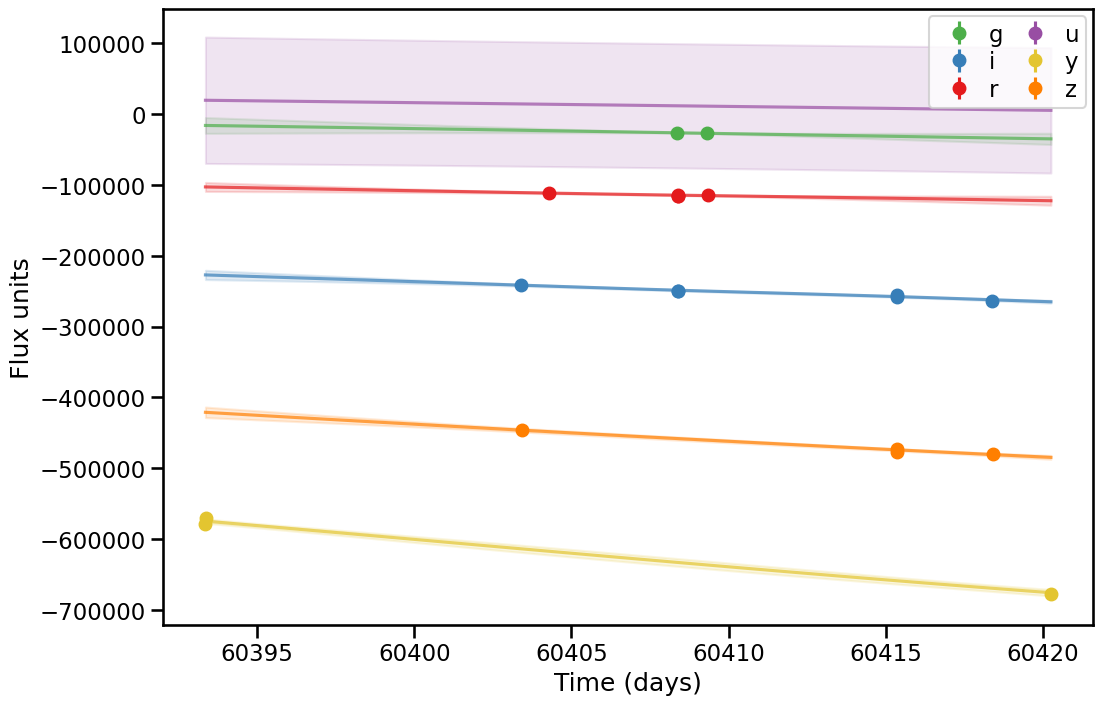

In [52]:
_obj_gps = generate_gp_single_event(data)
ax = plot_event_data_with_model(data, obj_model=_obj_gps, pb_colors=ELASTICC_PB_COLORS)

In [26]:
_obj_gps

,mjd,flux,flux_error,filter
0,60324.362200,-242.715084,171.154100,lsstu
1,60325.490917,-243.446087,170.031857,lsstu
2,60326.619634,-244.177615,168.920057,lsstu
3,60327.748352,-244.909662,167.818956,lsstu
4,60328.877069,-245.642225,166.728813,lsstu
...,...,...,...,...
595,60431.590331,-1000.097487,216.742573,lssty
596,60432.719048,-1000.837225,217.596380,lssty
597,60433.847766,-1001.573853,218.462498,lssty
598,60434.976483,-1002.307304,219.340728,lssty


In [ ]:
_obj_gps["filter"].unique()

In [ ]:
# N = 3
# seed = np.random.seed(1)
# indices = np.random.randint(0, len(sub), N)

# for index in indices:
#     fig = plt.figure(figsize=(12, 6))
    
#     data = sub.iloc[index]
#     filters = np.unique(data['cfilterName'])
    
#     for filt in filters:
#         cond = data['cfilterName'] == filt
        
#         plt.errorbar(
#             data['cmidPointTai'][cond], 
#             data['cpsFlux'][cond], 
#             data['cpsFluxErr'][cond],
#             ls='',
#             marker='o',
#             label='{} band'.format(filt)
#         )
#     plt.title('ID {} -- class: {}'.format(data['alertId'], data['classId']))
#     plt.legend()
#     plt.show()